In [1]:
#setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import timeit

In [2]:
#Read in data
df = pd.read_csv('../1 data preparation/20190401-20200312_items_prepped.csv')

# Lay the draw analysis

Now we've done our [data preparation](http://victorpapa.nl/sajiv/dataprep.html) and some first [benchmarking](http://victorpapa.nl/sajiv/first_benchmarks.html) analysis, it is time to start with what has been the main goal and focus point for this project: analyzing whether the lay the draw (LTD) strategy has been profitable for our sample dataset, and for which type of games.

In short, the lay the draw strategy contains:
- betting against the draw pre-game (i.e. bet on all other outcomes)
- closing out the position in-game by betting on the draw, when one of the teams scores and takes the lead.

The profitability of the bet depends on how much the draw-quote jumps after the goal is scored. Of course this depends on **who** scores (favourite or underdog), **when** it happens and other factors like openness of a match etc.

The strategy is used and has been analyzed by many. [Here](https://caanberry.com/laying-the-draw-tips/) it is argued it can be profitable but the match selection is key. [Here](https://sportstradinglife.com/2019/01/lay-the-draw-guide/) it is argued you should enter earliest at half time and later is better. That you should not overuse, do pre-game and in-game analysis, and not take your loss (stay in till the final whistle). And [this guy](https://sportstradinglife.com/2013/07/interviews-with-professional-gamblers-ian-erskine-fts/) claims he has made 1 million pounds in 7 years from lay the draw. Well, who knows.

It has to be mentioned that our benchmarking analysis showed a bias towards the draw in our sample dataset. This means that the pre-game draw quote was too high, which makes the LTD strategy more expensive. From this we could expect it not to be too profitable for our dataset. However we will still investigate.

## Calculation of LTD outcomes and profits

### Step 1: calculation of the back_X quote to beat (Q_beat)

**Q_beat**: the minimum back_X quote to close out the bet. In our strategy we close the bet the moment back_X equals or exceeds Q_beat.

The Q_beat quote entirely depends on the desired target_profit:
- desired_profit = 0: return from the lay bet with liability 1 is 1/(lay_X-1). we can close out the bet at Q_beat = (1+return)/return. If outcome is draw we lose 1 from lay bet and win 1 from closing bet. If outcome is no-draw we win return from lay bet and lose return from the closing bet.
- desired profit = 0.10: return from the lay bet with liability 1 is 1/(lay_X-1). we want to keep 0.10 from this so our stake for the closing bet is (return-0.10). Also we want the outcome of Q_beat * (return-0.10) to be 1+return.

Anyway, a formula is easier:

<img src="../0 images/Q_beat.png">

Note that if the desired target_profit is 0 (i.e. break even), Q_beat equals quote_lay, i.e. the lay_X quote used pre-game.

We set the desired profit equal to 10% for now, because approximately 10% of games end 0-0 (conservative estimate). And calculate the Q_beat for every observation in the Match Odds market:

In [3]:
target_profit = 0.10 #predefined target profit
df['return_lay'] = 1 / (df['lay_X'] - 1)
df['stake_close_max'] = df['return_lay'] - target_profit #maximum stake for closing the bet, making target_profit
df['Q_beat'] = (df['lay_X'] / (1 - (df['lay_X'] - 1) * target_profit)).round(2)
df['profit_Q_beat'] = df['Q_beat'] * df['stake_close_max'] - 1 - df['stake_close_max'] #approx equal to target_profit
df.loc[(df['market_name'] != 'Match Odds'),'Q_beat'] = np.nan

In [4]:
df[df['mins15'] == 0][['gametag','back_1','back_X','back_2','lay_X','Q_beat','return_lay','stake_close_max','profit_Q_beat']].head(5)

,gametag,back_1,back_X,back_2,lay_X,Q_beat,return_lay,stake_close_max,profit_Q_beat
94,20190401_ARSNEW,1.46,4.90,8.40,5.00,8.33,0.250000,0.150000,0.099500
388,20190401_ST NIM,1.79,4.00,5.10,4.10,5.94,0.322581,0.222581,0.099548
694,20190402_AC UDI,1.60,4.10,7.40,4.20,6.18,0.312500,0.212500,0.100750
926,20190402_CAGJUV,6.00,3.65,1.77,3.75,5.17,0.363636,0.263636,0.099364
1085,20190402_WATFUL,1.77,3.95,5.40,4.00,5.71,0.333333,0.233333,0.099000


### Sidestep: Lay_X bet or back_1/back_2 combi?

The back_1 and back_2 quotes together "imply" a lay_X quote. This can be different from the available lay_X quote. It can make a significant difference to calculate the difference and select the most advantageous of the 2.

In short: betting 1/back_1 on 1 and 1/back_2 on 2 will lead to:
- a profit of 1 - (1/back_1 + 1/back_2) if the outcome is not a draw
- a loss of 1/back_1 + 1/back_2 if the outcome is a draw

The liability of a lay bet is calculated as follows. From this the lay_X quote implied in the back_1 and back_2 quotes can be calculated:

<img src="../0 images/implied_lay_X.png">

We calculate this for the whole df:

In [5]:
df['back_impl_lay_X'] = 1 / (1 - (1/df['back_1'] + 1/df['back_2']))

In [6]:
df[df['mins15'] == 0][['gametag','lay_X','back_impl_lay_X']].head(5)

,gametag,lay_X,back_impl_lay_X
94,20190401_ARSNEW,5.00,5.101498
388,20190401_ST NIM,4.10,4.077267
694,20190402_AC UDI,4.20,4.169014
926,20190402_CAGJUV,3.75,3.726316
1085,20190402_WATFUL,4.00,4.002513


It is important to choose the **lowest** quote of the 2 when laying the draw.

PS: there is no direct arbitrage opportunity in this. It simply depends on which of the quotes is rounded down- or upwards. The balance probably constantly shifts over time.

### Step 2: Determination of Closed (True/False) and Q_close

Next we determine per game whether the LTD position could be closed, and at which quote. We can do this for our full dataframe at once. Both features will be dependent on the moment we started the strategy: mins15 == 0, 15, 30, 45, 60 or 75. For now we will set it at 0 (start of the game).

In [7]:
LTD_start = 0

For every gametag we basically have to find:
- whether there are observations (after LTD_start) with back_X >= Q_beat or not --> Closed true or false
- if yes, what is the first back_X observation after LTD_start that is >= Q_beat --> Q_close

In [8]:
start = timeit.default_timer()
print("to do: ",len(df[df['mins15'] == LTD_start]['gametag'].unique()))
for (count,gametag) in enumerate(df[df['mins15'] == LTD_start]['gametag'].unique()):
    print(count,"\r",end="")
    #sub1: all Match Odds observations for this game, after LTD_start
    ltdstart_row_idx = df[(df['gametag'] == gametag) & (df['mins15'] == LTD_start)].index[0]
    df_sub = df[(df['gametag'] == gametag) & (df['market_name'] == 'Match Odds')].loc[ltdstart_row_idx:,:]
    #set Q-beat equal to the Q_beat at LTD_start for all observations
    df_sub.loc[:,'Q_beat'] = df_sub[(df_sub['mins15'] == LTD_start)]['Q_beat'].iloc[0]
    #sub2: all observations with back_X >= Q_beat
    df_sub = df_sub[df_sub['back_X'] >= df_sub['Q_beat']]
    #store Close and Q_close
    if (df_sub.shape[0] == 0):
        df.loc[ltdstart_row_idx,'Close'] = False
        df.loc[ltdstart_row_idx,'Q_close'] = np.nan
        df.loc[ltdstart_row_idx,'gametime_close'] = np.nan
    else:
        df.loc[ltdstart_row_idx,'Close'] = True
        df.loc[ltdstart_row_idx,'Q_close'] = df_sub['back_X'].iloc[0]
        df.loc[ltdstart_row_idx,'gametime_close'] = df_sub['current_gametime_T2'].iloc[0] 
stop = timeit.default_timer()
print('Runtime: ', stop - start)

to do:  840
Runtime:  27.057326200000006


We see for instance that 20190401_ARSNEW could be closed out in min 32' at Q_close quote 9.0, a little higher than Q_beat 8.33 and thus locking in a little more than the desired profit of 10%. 20190403_ROMFIO could never be closed out and ended in the draw, resulting in a loss of -100%:

In [9]:
df[df['mins15'] == 0][['gametag','back_F_calib','endscore','Q_beat','Close','gametime_close','Q_close']].head(20)

,gametag,back_F_calib,endscore,Q_beat,Close,gametime_close,Q_close
94,20190401_ARSNEW,1.46,2-0,8.33,True,32.0,9.0
388,20190401_ST NIM,1.78,2-1,5.94,True,87.0,7.4
694,20190402_AC UDI,1.60,1-1,6.18,True,45.0,6.8
926,20190402_CAGJUV,1.78,0-2,5.17,True,26.0,6.6
1085,20190402_WATFUL,1.77,3-1,5.71,True,74.0,36.0
1192,20190402_WOLMAN,2.50,2-1,4.19,True,16.0,4.7
1379,20190403_ATHLEV,1.52,3-2,8.03,True,30.0,22.0
1487,20190403_EMPNAP,1.58,2-1,7.74,True,93.0,9.8
1595,20190403_GENINT,1.96,0-3,5.17,True,17.0,5.4
1687,20190403_MONGUI,1.93,2-0,4.77,True,22.0,4.9


It has to be noted that not all Close = False observations are losses. From above:
- 20190404_LEGVAL had a very late goal and no new observation with a high back_X quote anymore
- 20190405_SOULIV has such a high Q_beat that it does not have a back_X that high (because 87' is the last observation)

Also:
- 20190406_RAYVAL: underdog scores -> quote does not jump high enough to close (last observation is 72')
- 20190407_FIOFRO: underdog scores -> quote does not jump high enough to close (last observation still has back_F 1.19)
- 20190414_WIGNOR: underdog scores, back_X doesn't reach Q_beat before favourite equalizes
- 20190415_LEGREA: underdog scores, back_X doesn't reach Q_beat before favourite equalizes

We could change our strategy that if the underdog scores first, we close out once we can get break even. But let's first continue our analysis as-is.

#### Outcomes

There are 3 possible outcomes:
- we have not closed but still won (endscore is not a draw) -> profit = return from lay bet
- we have not closed and lost (endscore is draw) -> profit = -1
- we have closed and locked in a profit -> profit can be calculated as follows:

<img src="../0 images/profit_close.png">

In [10]:
#outcome
df.loc[(df['endscore_label'] == 'F+0') & (df['Close'] == False),'outcome'] = 'open_loss'
df.loc[(df['endscore_label'] != 'F+0') & (df['Close'] == False),'outcome'] = 'open_win'
df.loc[(df['Close'] == True),'outcome'] = 'closed_win'

In [11]:
df['outcome'].value_counts()

closed_win    676
open_loss     125
open_win       39
Name: outcome, dtype: int64

In [12]:
#closed_win
df.loc[df['outcome'] == 'closed_win','stake_close'] = (1+target_profit+df['stake_close_max'])/(df['Q_close']) #stake needed for closing the bet, making target_profit
df.loc[df['outcome'] == 'closed_win','profit_close'] = target_profit + df['stake_close_max'] - df['stake_close']

In [13]:
#open_loss
df.loc[df['outcome'] == 'open_loss','profit_close'] = -1

In [14]:
#open_win
df.loc[df['outcome'] == 'open_win','profit_close'] = df['return_lay']

In [15]:
df[df['mins15'] == 0][['gametag','back_1','back_X','back_2','lay_X','Q_beat','return_lay','stake_close_max',
                       'endscore','Close','Q_close','stake_close','profit_close']].head(20)

,gametag,back_1,back_X,back_2,lay_X,Q_beat,return_lay,stake_close_max,endscore,Close,Q_close,stake_close,profit_close
94,20190401_ARSNEW,1.46,4.90,8.40,5.00,8.33,0.250000,0.150000,2-0,True,9.0,0.138889,0.111111
388,20190401_ST NIM,1.79,4.00,5.10,4.10,5.94,0.322581,0.222581,2-1,True,7.4,0.178727,0.143854
694,20190402_AC UDI,1.60,4.10,7.40,4.20,6.18,0.312500,0.212500,1-1,True,6.8,0.193015,0.119485
926,20190402_CAGJUV,6.00,3.65,1.77,3.75,5.17,0.363636,0.263636,0-2,True,6.6,0.206612,0.157025
1085,20190402_WATFUL,1.77,3.95,5.40,4.00,5.71,0.333333,0.233333,3-1,True,36.0,0.037037,0.296296
1192,20190402_WOLMAN,3.40,3.20,2.54,3.25,4.19,0.444444,0.344444,2-1,True,4.7,0.307329,0.137116
1379,20190403_ATHLEV,1.52,4.80,7.00,4.90,8.03,0.256410,0.156410,3-2,True,22.0,0.057110,0.199301
1487,20190403_EMPNAP,6.20,4.70,1.57,4.80,7.74,0.263158,0.163158,2-1,True,9.8,0.128894,0.134264
1595,20190403_GENINT,4.40,3.70,1.96,3.75,5.17,0.363636,0.263636,0-3,True,5.4,0.252525,0.111111
1687,20190403_MONGUI,1.93,3.40,5.00,3.55,4.77,0.392157,0.292157,2-0,True,4.9,0.284114,0.108043


### Step 3: Results

If we would have played on all 840 games, starting at T=0, then we would have made a total loss of 7.15 times our stake per game:

In [16]:
df['profit_close'].sum()

-7.151865050210493

In [17]:
df['profit_close'].sum() / df['profit_close'].count()

-0.008514125059774396

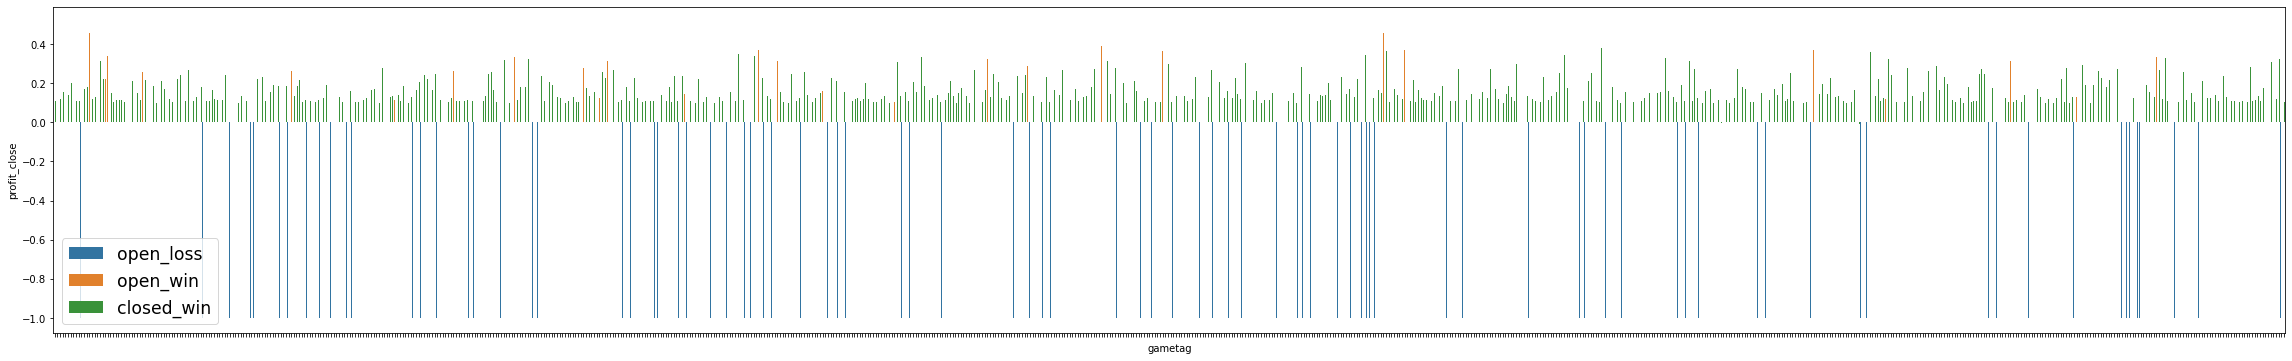

In [18]:
plt.figure(figsize=(40,6))
p = sns.barplot(data=df[df['mins15'] == 0],x='gametag',y='profit_close',hue='outcome',
                hue_order=['open_loss','open_win','closed_win'])
plt.legend(fontsize = 'xx-large')
p.set_xticklabels("");

Let's quickly have a look at our losing games. How many of them ended 0-0 and how many did the underdog take the lead?

In [19]:
#out of the 125 losses, 57 were 0-0 games
df[df['outcome'] == 'open_loss']['endscore'].value_counts()

0-0    57
1-1    57
2-2    11
Name: endscore, dtype: int64

In [20]:
#who took the lead: favourite or underdog?
tags = df[df['outcome'] == 'open_loss']['gametag']
df_sub = df[(df['gametag'].isin(tags)) & (df['lead_shift']) & (df['market_name'] == 'Match Odds')].copy()
df_sub.loc[:,'lead_taker'] = df_sub['score_diff_label'].str[0:2]
cross = pd.crosstab(columns=df_sub['lead_taker'],index=df_sub['gametag'])
cross.head(3)

lead_taker,F+,F-
gametag,,
20190403_ROMFIO,0,2
20190414_WIGNOR,0,1
20190415_LEGREA,0,1


In [21]:
#in 54 out of 69 games that ended 1-1 or 2-2, the underdog took the lead at least once
cross[cross['F-'] > 0].index.shape

(54,)

### What-if: strategy close at 0 profit if underdog takes the lead

So it looks like many of our losing games are games where the underdog took the lead. This makes sense because the probability of a draw might actually **increase** in that event, or at least not decrease too much. Thus the back_X quote will not rise enough for us to lock in the 10%. In many of these games the favourite then equalizes and the game ends in a draw.

What if we would change our strategy and **close out the bet at 0% profit if the underdog takes the lead**?

In [22]:
df['target_profit'] = target_profit

start = timeit.default_timer()
print("to do: ",len(df[df['mins15'] == LTD_start]['gametag'].unique()))
for (count,gametag) in enumerate(df[df['mins15'] == LTD_start]['gametag'].unique()):
    print(count,"\r",end="")
    #sub1: all Match Odds observations for this game, after LTD_start
    ltdstart_row_idx = df[(df['gametag'] == gametag) & (df['mins15'] == LTD_start)].index[0]
    df_sub = df[(df['gametag'] == gametag) & (df['market_name'] == 'Match Odds')].loc[ltdstart_row_idx:,:]
    #set Q-beat equal to the Q_beat at LTD_start for all observations
    df_sub.loc[:,'Q_beat'] = df_sub[(df_sub['mins15'] == LTD_start)]['Q_beat'].iloc[0]
    #set Q-beat equal to the lay_X at start if the underdog is leading
    Q_beat_und = df_sub[(df_sub['mins15'] == LTD_start)]['lay_X'].iloc[0]
    df_sub.loc[(df_sub['score_diff_label'].str[0:2] == "F-"),'Q_beat'] = Q_beat_und
    df_sub.loc[(df_sub['score_diff_label'].str[0:2] == "F-"),'target_profit'] = 0
        
    #sub2: all observations with back_X >= Q_beat
    df_sub = df_sub[df_sub['back_X'] >= df_sub['Q_beat']]
    #store Close and Q_close
    if (df_sub.shape[0] == 0):
        df.loc[ltdstart_row_idx,'Close'] = False
        df.loc[ltdstart_row_idx,'Q_close'] = np.nan
        df.loc[ltdstart_row_idx,'gametime_close'] = np.nan
    else:
        df.loc[ltdstart_row_idx,'Close'] = True
        df.loc[ltdstart_row_idx,'Q_close'] = df_sub['back_X'].iloc[0]
        df.loc[ltdstart_row_idx,'gametime_close'] = df_sub['current_gametime_T2'].iloc[0]
        df.loc[ltdstart_row_idx,'target_profit'] = df_sub['target_profit'].iloc[0]
        df.loc[ltdstart_row_idx,'stake_close_max'] = df.loc[ltdstart_row_idx,'return_lay'] - df.loc[ltdstart_row_idx,'target_profit']

stop = timeit.default_timer()
print('Runtime: ', stop - start)

to do:  840
Runtime:  30.636826500000012


In [23]:
#outcome
df.loc[(df['endscore_label'] == 'F+0') & (df['Close'] == False),'outcome'] = 'open_loss'
df.loc[(df['endscore_label'] != 'F+0') & (df['Close'] == False),'outcome'] = 'open_win'
df.loc[(df['Close'] == True),'outcome'] = 'closed_win'
#closed_win
df.loc[df['outcome'] == 'closed_win','stake_close'] = (1+df['target_profit']+ df['stake_close_max'])/(df['Q_close']) #stake needed for closing the bet, making target_profit
df.loc[df['outcome'] == 'closed_win','profit_close'] = df['target_profit'] + df['stake_close_max'] - df['stake_close']
#open_loss
df.loc[df['outcome'] == 'open_loss','profit_close'] = -1
#open_win
df.loc[df['outcome'] == 'open_win','profit_close'] = df['return_lay']

We see that we now close 20190403_ROMFIO (at approximately 0), but also a game like 20190401_ST NIM	where the underdog Nimes first took the lead:

In [24]:
df[df['mins15'] == 0][['gametag','back_1','back_X','back_2','lay_X','Q_beat','return_lay','stake_close_max',
                       'endscore','Close','Q_close','stake_close','profit_close']].head(20)

,gametag,back_1,back_X,back_2,lay_X,Q_beat,return_lay,stake_close_max,endscore,Close,Q_close,stake_close,profit_close
94,20190401_ARSNEW,1.46,4.90,8.40,5.00,8.33,0.250000,0.150000,2-0,True,9.00,0.138889,0.111111
388,20190401_ST NIM,1.79,4.00,5.10,4.10,5.94,0.322581,0.322581,2-1,True,4.10,0.322581,0.000000
694,20190402_AC UDI,1.60,4.10,7.40,4.20,6.18,0.312500,0.212500,1-1,True,6.80,0.193015,0.119485
926,20190402_CAGJUV,6.00,3.65,1.77,3.75,5.17,0.363636,0.263636,0-2,True,6.60,0.206612,0.157025
1085,20190402_WATFUL,1.77,3.95,5.40,4.00,5.71,0.333333,0.233333,3-1,True,36.00,0.037037,0.296296
1192,20190402_WOLMAN,3.40,3.20,2.54,3.25,4.19,0.444444,0.344444,2-1,True,4.70,0.307329,0.137116
1379,20190403_ATHLEV,1.52,4.80,7.00,4.90,8.03,0.256410,0.156410,3-2,True,22.00,0.057110,0.199301
1487,20190403_EMPNAP,6.20,4.70,1.57,4.80,7.74,0.263158,0.263158,2-1,True,5.40,0.233918,0.029240
1595,20190403_GENINT,4.40,3.70,1.96,3.75,5.17,0.363636,0.263636,0-3,True,5.40,0.252525,0.111111
1687,20190403_MONGUI,1.93,3.40,5.00,3.55,4.77,0.392157,0.292157,2-0,True,4.90,0.284114,0.108043


However if we would have played this second strategy on all of our 840 games, we would have made a small profit:

In [25]:
df['profit_close'].sum()

1.984424746328949

In [26]:
df['profit_close'].sum() / df['profit_close'].count()

0.0023624104122963677

Note that this 'profit_close' does not yet take into account the bookie margin of 6.5% taken on profits. We will include this in the analysis below, when we build a routine for calculating profits for all possible strategies.

In [27]:
df['outcome'].value_counts()

closed_win    716
open_loss      93
open_win       31
Name: outcome, dtype: int64

Less losses (93 instead of 125), at the cost of lower profits.

In [28]:
#out of the 99 losses, 56 were 0-0 games
df[df['outcome'] == 'open_loss']['endscore'].value_counts()

0-0    56
1-1    33
2-2     4
Name: endscore, dtype: int64

### Selecting the right matches: subset selection

We expect that playing on all games is not the best strategy, and there will be differences in games based on the degree on favouritism, measured by back_F.

C:\Users\nverd\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


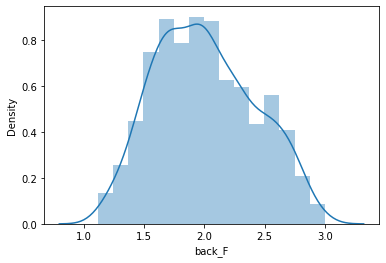

In [29]:
#distribution of pre-game favouritism in our dataset (low back_F score means high favouritism)
sns.distplot(df[df['mins15'] == 0]['back_F'])

Let's split into 4 equal categories:

In [30]:
df.loc[:,'back_F_factor'] = pd.qcut(df[df['mins15'] == 0]['back_F'], q = [0, .25, .5, .75, 1.])
df['back_F_factor'].value_counts()

(1.688, 1.97]                  213
(1.97, 2.3]                    211
(1.1190000000000002, 1.688]    210
(2.3, 3.0]                     206
Name: back_F_factor, dtype: int64

We'll continue to explore the quote variation within 1 category: 1.69-1.97 favourites, home and away.

In [31]:
df_sub = df[(df['back_F'] >= 1.69) & (df['back_F'] <= 1.97) & (df['mins15'] == 0)].copy()

In [33]:
df_sub.shape

(213, 73)

In [34]:
df_sub[['gametag','back_F','back_X','back_U']].sort_values('back_F')

,gametag,back_F,back_X,back_U
30324,20191228_NORTOT,1.69,4.70,5.0
22625,20190505_SASFRO,1.69,4.00,5.9
37198,20200105_CHAWES,1.69,4.30,5.4
20629,20190430_NEWOLD,1.69,4.20,5.7
117728,20200308_RANMID,1.70,4.20,5.5
...,...,...,...,...
37454,20200105_FAMSET,1.97,3.80,4.2
50967,20200118_OSAVAL,1.97,3.45,4.9
93954,20200222_FREFOR,1.97,3.90,4.1
24661,20191221_NORWOL,1.97,3.85,4.2


In [35]:
#preparation for plot below: melt table (make columns rows)
df_sub2 = df_sub[['gametag','back_F','back_X','back_U']].sort_values('back_F')
df_sub_melted = df_sub2.melt(id_vars=["gametag"], var_name="back", value_name="Value")
df_sub_melted[df_sub_melted['gametag'] == '20190403_GENINT']

,gametag,back,Value
195,20190403_GENINT,back_F,1.96
408,20190403_GENINT,back_X,3.70
621,20190403_GENINT,back_U,4.40


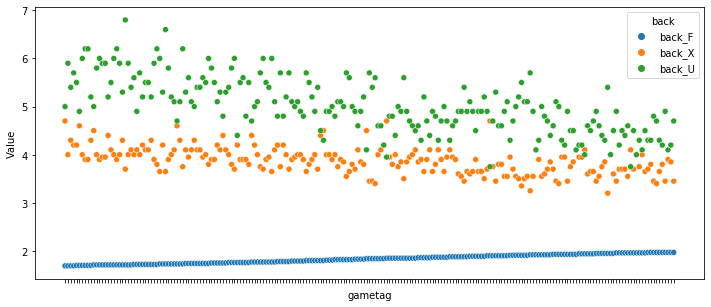

In [36]:
#plot the variation in quotes for the subgroup
plt.figure(figsize=(12,5))
p = sns.scatterplot(data=df_sub_melted,x='gametag',y='Value',hue='back')
p.set_xticklabels("");

There is quite some variation. The X quote seems to vary between +/- 3.40 and 4.80 for this relatively small range of back_F (1.69-1.97). Probably this is because some games have "high scoring likelihood" and some low. We have a measure for this: the quote that there will be no goals ('back_noscore_calib')

C:\Users\nverd\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


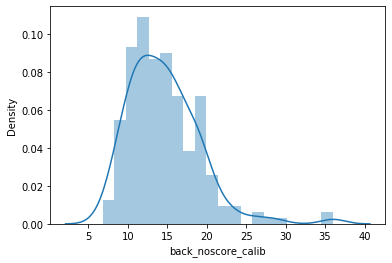

In [37]:
sns.distplot(df_sub['back_noscore_calib'],bins=20)

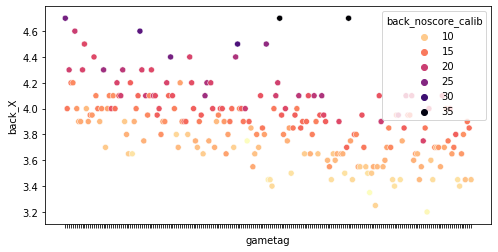

In [38]:
#plot the variation in quotes
df_sub2 = df_sub[['gametag','back_F','back_X','back_U','back_noscore_calib']].sort_values('back_F')
plt.figure(figsize=(8,4))
p = sns.scatterplot(data=df_sub2,x='gametag',y='back_X',
                    hue='back_noscore_calib',palette='magma_r')
p.set_xticklabels("");

Lower back_X quotes represent games with a low "scoring likelihood" represented by the back_noscore quote. There is quite a clear relationship:

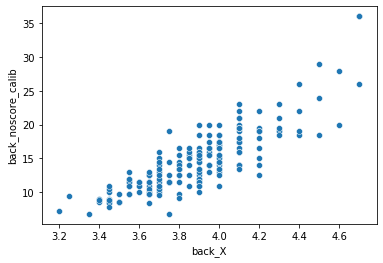

In [39]:
sns.scatterplot(data=df_sub,x='back_X',y='back_noscore_calib')

We will seperate the bottom 20% and top 25% from the middle 55%:

In [40]:
df_sub.loc[:,'back_noscore_calib_factor'] = pd.qcut(df_sub['back_noscore_calib'], q = [0, .2, .75, 1.])

In [41]:
df_sub['back_noscore_calib_factor'].value_counts()

(11.0, 17.0]                  110
(17.0, 36.0]                   53
(6.7989999999999995, 11.0]     50
Name: back_noscore_calib_factor, dtype: int64

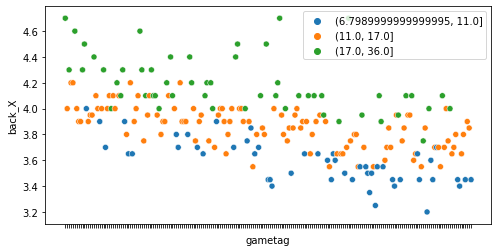

In [42]:
df_sub3 = df_sub[['gametag','back_F','back_X','back_U','back_noscore_calib_factor']].sort_values('back_F')
plt.figure(figsize=(8,4))
p = sns.scatterplot(data=df_sub3,x='gametag',y='back_X',
                    hue='back_noscore_calib_factor',cmap='viridis')
p.set_xticklabels("")
p.legend(loc='upper right')

So we will seperate the games based on:
- degree of favouritism, measured by back_F
- degree of (pre-game) scoring likelihood, measured by back_noscore_calib

In [43]:
#there are 110 games with 1.69-1.97 favouritism and 11.00-17.00 scoring likelihood
df_sub = df[(df['back_F'] >= 1.69) & (df['back_F'] <= 1.97) & 
           (df['back_noscore_calib'] > 11) & (df['back_noscore_calib'] <= 17)].copy()
df_sub[df_sub['mins15'] == 0].shape

(110, 73)

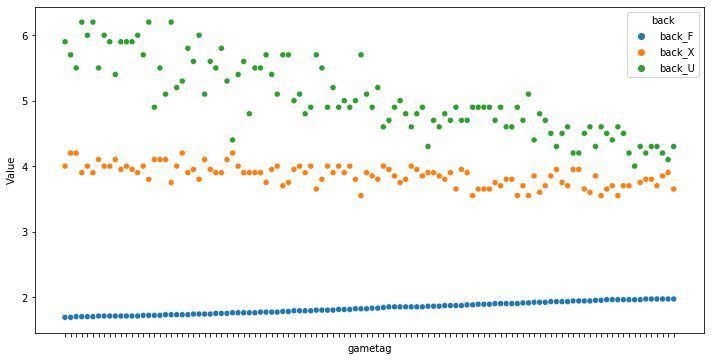

In [44]:
#variation in quotes should have decreased by taking this subset
df_sub2 = df_sub[df_sub['mins15'] == 0][['gametag','back_F','back_X','back_U']].sort_values('back_F')
df_sub_melted = df_sub2.melt(id_vars=["gametag"], var_name="back", value_name="Value")
plt.figure(figsize=(12,6))
p = sns.scatterplot(data=df_sub_melted,x='gametag',y='Value',hue='back')
p.set_xticklabels("");

The draw quotes are now all a bit in the same range indeed...

### Conclusion subgroups

We will analyze the outcomes of both strategies for:
- 4 groups of favouritism, equally divided
- 3 groups of pre-game 'scoring likelihood', measured by the back_noscore_calib: bottom 20%, middle 55% and top 25%. Defined per favouritism category seperately.

That makes **12 groups** in total. 

Making the groups at the start of the game (mins15 == 0), gives the following observation counts:

In [45]:
#back_F cut
df.loc[:,'back_F_factor'] = pd.qcut(df[df['mins15'] == 0]['back_F'], 
                                    q = [0, .25, .5, .75, 1.], labels = ["F++++","F+++","F++","F+"])

In [46]:
#back_noscore_calib cut made for each back_F category seperately
for F_interval in df['back_F_factor'].unique().dropna():
    df.loc[(df['back_F_factor'] == F_interval),'back_noscore_calib_factor'] = pd.qcut(df[df['back_F_factor'] == F_interval]['back_noscore_calib'], 
                                                    q = [0, 0.20, 0.75, 1],labels=['low','middle','high'])

In [47]:
#counts
pd.crosstab(index=df['back_F_factor'],columns=df['back_noscore_calib_factor'])

back_noscore_calib_factor,high,low,middle
back_F_factor,,,
F++++,50,44,116
F+++,53,50,110
F++,47,44,120
F+,48,46,112


In [48]:
piv = df[df['mins15'] == 0].pivot_table(values='profit_close',index='back_F_factor',
                                  columns='back_noscore_calib_factor',aggfunc='count',margins=True)
piv[['low', 'middle','high','All']]

back_noscore_calib_factor,low,middle,high,All
back_F_factor,,,,
F++++,44,116,50,210
F+++,50,110,53,213
F++,44,120,47,211
F+,46,112,48,206
All,184,458,198,840


In [49]:
#back_F_factor cutoffs
df.groupby('back_F_factor')['back_F'].min()

back_F_factor
F++++    1.12
F+++     1.69
F++      1.98
F+       2.32
Name: back_F, dtype: float64

In [50]:
#back_noscore_calib_factor cutoffs per back_F category
pd.crosstab(index=df['back_F_factor'],columns=df['back_noscore_calib_factor'],values=df['back_noscore_calib'],aggfunc=min)

back_noscore_calib_factor,high,low,middle
back_F_factor,,,
F++++,24.0,2.46,15.5
F+++,17.5,6.80,11.5
F++,16.5,6.00,9.8
F+,15.5,5.50,8.4


### Strategy results for subgroup: [1.69-1.97] favouritism and [11.50-17.00] scoring likelihood

In [51]:
LTD_start = 0
target_profit = 0.10

Q_beat has already been calculated above for LTD_start = 0 and target_profit = 0.10. We will use that for now, and make the parameters flexible below when creating the routine.

#### Strategy 1

In [62]:
df.drop(['Close', 'Q_close', 'gametime_close', 'outcome', 'stake_close', 'profit_close'], axis=1,inplace=True)

In [63]:
tags = df[(df['back_F_factor'] == 'F+++') & (df['back_noscore_calib_factor'] == 'middle')]['gametag'].unique()
tags.shape[0]

110

In [64]:
start = timeit.default_timer()
print("to do: ",len(tags))
for (count,gametag) in enumerate(tags):
    print(count,"\r",end="")
    #sub1: all Match Odds observations for this game, after LTD_start
    ltdstart_row_idx = df[(df['gametag'] == gametag) & (df['mins15'] == LTD_start)].index[0]
    df_sub = df[(df['gametag'] == gametag) & (df['market_name'] == 'Match Odds')].loc[ltdstart_row_idx:,:]
    #set Q-beat equal to the Q_beat at LTD_start for all observations
    df_sub.loc[:,'Q_beat'] = df_sub[(df_sub['mins15'] == LTD_start)]['Q_beat'].iloc[0]
    #sub2: all observations with back_X >= Q_beat
    df_sub = df_sub[df_sub['back_X'] >= df_sub['Q_beat']]
    #store Close and Q_close
    if (df_sub.shape[0] == 0):
        df.loc[ltdstart_row_idx,'Close'] = False
        df.loc[ltdstart_row_idx,'Q_close'] = np.nan
        df.loc[ltdstart_row_idx,'gametime_close'] = np.nan
    else:
        df.loc[ltdstart_row_idx,'Close'] = True
        df.loc[ltdstart_row_idx,'Q_close'] = df_sub['back_X'].iloc[0]
        df.loc[ltdstart_row_idx,'gametime_close'] = df_sub['current_gametime_T2'].iloc[0] 
stop = timeit.default_timer()
print('Runtime: ', stop - start)

to do:  110
Runtime:  3.6870124000000146


In [65]:
#outcome
df.loc[(df['endscore_label'] == 'F+0') & (df['Close'] == False),'outcome'] = 'open_loss'
df.loc[(df['endscore_label'] != 'F+0') & (df['Close'] == False),'outcome'] = 'open_win'
df.loc[(df['Close'] == True),'outcome'] = 'closed_win'
#closed_win
df.loc[df['outcome'] == 'closed_win','stake_close'] = (1+target_profit + df['stake_close_max'])/(df['Q_close']) #stake needed for closing the bet, making target_profit
df.loc[df['outcome'] == 'closed_win','profit_close'] = target_profit + df['stake_close_max'] - df['stake_close']
#open_loss
df.loc[df['outcome'] == 'open_loss','profit_close'] = -1
#open_win
df.loc[df['outcome'] == 'open_win','profit_close'] = df['return_lay']

In [66]:
df['outcome'].value_counts()

closed_win    96
open_loss     11
open_win       3
Name: outcome, dtype: int64

In [67]:
df['profit_close'].sum()

5.930606872944035

In [68]:
df['profit_close'].sum() / df['profit_close'].count()

0.05391460793585487

5% profit. Note again: this does not include the 6.5% bookie margin taken on all profits. This will be accounted for in the routine.

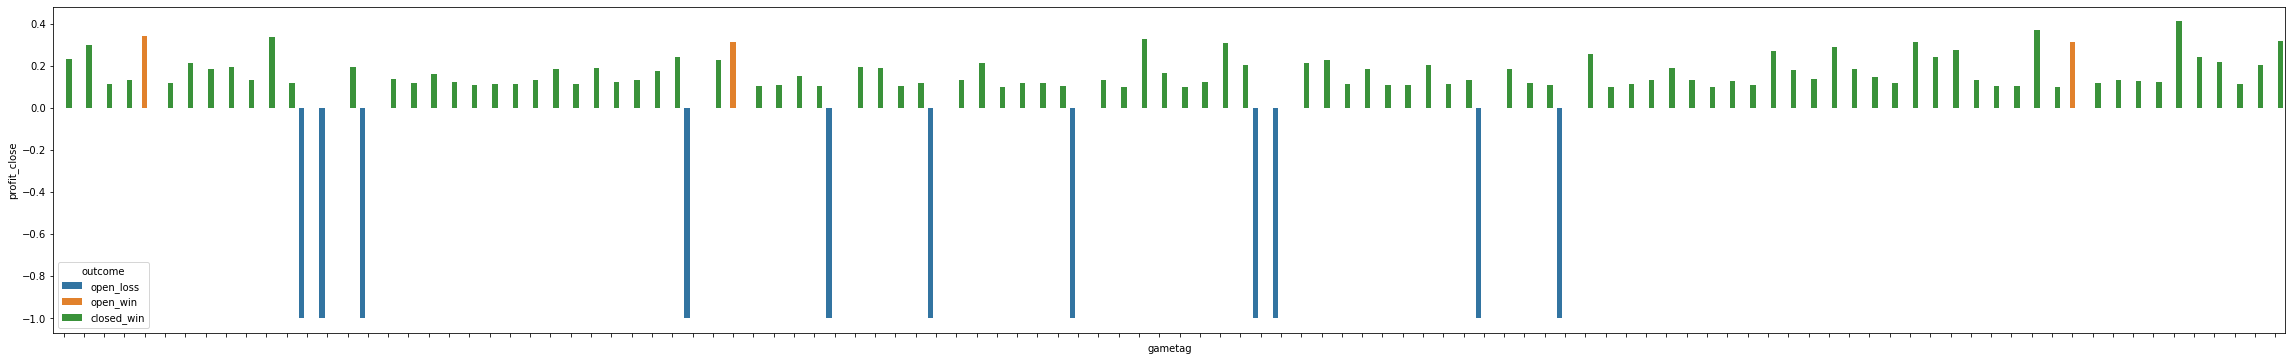

In [69]:
plt.figure(figsize=(40,6))
p = sns.barplot(data=df[(df['mins15'] == 0) & (df['gametag'].isin(tags))],x='gametag',y='profit_close',hue='outcome',
                hue_order=['open_loss','open_win','closed_win'])
p.set_xticklabels("");

From the 110 games 11 end up in a loss.

In [70]:
df[df['outcome'] == 'open_loss']['endscore'].value_counts()

1-1    6
0-0    5
Name: endscore, dtype: int64

#### Strategy 2

In [71]:
df.drop(['Close', 'Q_close', 'gametime_close', 'outcome', 'stake_close', 'profit_close'], axis=1,inplace=True)

In [73]:
tags = df[(df['back_F_factor'] == 'F+++') & (df['back_noscore_calib_factor'] == 'middle')]['gametag'].unique()
tags.shape[0]

110

In [74]:
df['target_profit'] = target_profit

start = timeit.default_timer()
print("to do: ",len(tags))
for (count,gametag) in enumerate(tags):
    print(count,"\r",end="")
    #sub1: all Match Odds observations for this game, after LTD_start
    ltdstart_row_idx = df[(df['gametag'] == gametag) & (df['mins15'] == LTD_start)].index[0]
    df_sub = df[(df['gametag'] == gametag) & (df['market_name'] == 'Match Odds')].loc[ltdstart_row_idx:,:]
    #set Q-beat equal to the Q_beat at LTD_start for all observations
    df_sub.loc[:,'Q_beat'] = df_sub[(df_sub['mins15'] == LTD_start)]['Q_beat'].iloc[0]
    #set Q-beat equal to the lay_X at start if the underdog is leading
    Q_beat_und = df_sub[(df_sub['mins15'] == LTD_start)]['lay_X'].iloc[0]
    df_sub.loc[(df_sub['score_diff_label'].str[0:2] == "F-"),'Q_beat'] = Q_beat_und
    df_sub.loc[(df_sub['score_diff_label'].str[0:2] == "F-"),'target_profit'] = 0
        
    #sub2: all observations with back_X >= Q_beat
    df_sub = df_sub[df_sub['back_X'] >= df_sub['Q_beat']]
    #store Close and Q_close
    if (df_sub.shape[0] == 0):
        df.loc[ltdstart_row_idx,'Close'] = False
        df.loc[ltdstart_row_idx,'Q_close'] = np.nan
        df.loc[ltdstart_row_idx,'gametime_close'] = np.nan
    else:
        df.loc[ltdstart_row_idx,'Close'] = True
        df.loc[ltdstart_row_idx,'Q_close'] = df_sub['back_X'].iloc[0]
        df.loc[ltdstart_row_idx,'gametime_close'] = df_sub['current_gametime_T2'].iloc[0]
        df.loc[ltdstart_row_idx,'target_profit'] = df_sub['target_profit'].iloc[0]
        df.loc[ltdstart_row_idx,'stake_close_max'] = df.loc[ltdstart_row_idx,'return_lay'] - df.loc[ltdstart_row_idx,'target_profit']
stop = timeit.default_timer()
print('Runtime: ', stop - start)

to do:  110
Runtime:  4.336398499999973


In [75]:
#outcome
df.loc[(df['endscore_label'] == 'F+0') & (df['Close'] == False),'outcome'] = 'open_loss'
df.loc[(df['endscore_label'] != 'F+0') & (df['Close'] == False),'outcome'] = 'open_win'
df.loc[(df['Close'] == True),'outcome'] = 'closed_win'
#closed_win
df.loc[df['outcome'] == 'closed_win','stake_close'] = (1+df['target_profit']+ df['stake_close_max'])/(df['Q_close']) #stake needed for closing the bet, making target_profit
df.loc[df['outcome'] == 'closed_win','profit_close'] = df['target_profit'] + df['stake_close_max'] - df['stake_close']
#open_loss
df.loc[df['outcome'] == 'open_loss','profit_close'] = -1
#open_win
df.loc[df['outcome'] == 'open_win','profit_close'] = df['return_lay']

In [76]:
df['outcome'].value_counts()

closed_win    97
open_loss     10
open_win       3
Name: outcome, dtype: int64

In [77]:
df[(df['mins15'] == 0) & (df['gametag'].isin(tags))][['gametag','back_F','back_X','lay_X','Q_beat','return_lay','target_profit','stake_close_max',
                       'endscore','Close','Q_close','stake_close','profit_close']].head()

,gametag,back_F,back_X,lay_X,Q_beat,return_lay,target_profit,stake_close_max,endscore,Close,Q_close,stake_close,profit_close
388,20190401_ST NIM,1.79,4.00,4.10,5.94,0.322581,0.0,0.322581,2-1,True,4.1,0.322581,0.000000
1085,20190402_WATFUL,1.77,3.95,4.00,5.71,0.333333,0.1,0.233333,3-1,True,36.0,0.037037,0.296296
1595,20190403_GENINT,1.96,3.70,3.75,5.17,0.363636,0.1,0.263636,0-3,True,5.4,0.252525,0.111111
2467,20190404_SASCHI,1.75,3.90,3.95,5.60,0.338983,0.1,0.238983,4-0,True,6.4,0.209216,0.129767
3251,20190406_BARATL,1.77,3.90,3.95,5.60,0.338983,0.1,0.238983,2-0,False,NaN,NaN,0.338983


In [78]:
df['profit_close'].sum()

2.685437886998767

In [79]:
df['profit_close'].sum() / df['profit_close'].count()

0.024413071699988794

2.5% profit.

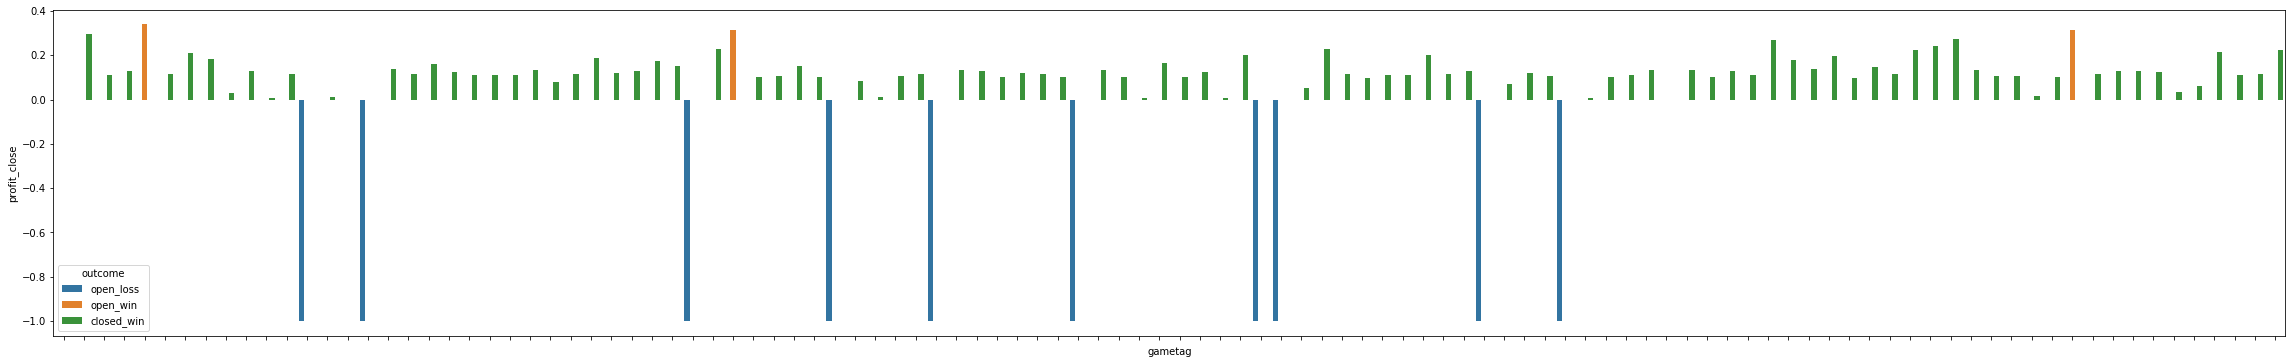

In [80]:
plt.figure(figsize=(40,6))
p = sns.barplot(data=df[(df['mins15'] == 0) & (df['gametag'].isin(tags))],x='gametag',y='profit_close',hue='outcome',
                hue_order=['open_loss','open_win','closed_win'])
p.set_xticklabels("");

11 become 10 losses.

In [81]:
df[df['outcome'] == 'open_loss']['endscore'].value_counts()

0-0    5
1-1    5
Name: endscore, dtype: int64

# Routine

We want to create a routine that takes the prepped dataframe and the following parameters:
- **LTD_start** = when to start the strategy. Values: 0, 15, 30, 45, 60 or 75. Default 0.
- **target_profit** = profit percentage at which bet closure takes place. Value between 0 and 1. Default 0.10.
- **underdog_lead_target_profit** = profit percentage at which bet closure takes place, when underdog leads. Value between 0 and 1. Default 0.10.
- **back_F_qcut** = list quantiles to create back_F categories. Default [0, .25, .5, .75, 1.]
- **back_noscore_qcut** = list quantiles to create back_noscore categories. Default [0, .20, .75, 1.]

Dependent on LTD_start, target_profit underdog_lead_target_profit, it then calculates:
- Q_beat
- Close
- Q_close
- gametime_close
- outcome
- profit_close

It will also:
- calculate the net_profit which is 93.5% of profit_close (if positive). Profit commission will default 6.5% but can be set as parameter
- create the back_F_factor and back_noscore_calib_factor categories allowing for analysis per category

The routine returns the complete enriched dataframe, which then can be used to create pivot tables, visualizations, profit-per-game summaries etc.

In [82]:
def profit_table(df, LTD_start = 0, target_profit = 0.10, underdog_lead_target_profit = 0.10, profit_commission = 0.065,
                 back_F_qcut = [0, .25, .5, .75, 1.], back_noscore_qcut = [0, .20, .75, 1.]):
    '''
    This function takes in the whole prepped dataframe and some strategy parameters:
    - LTD_start = when to start the strategy. Possible values: 0, 15, 30, 45, 60 or 75. Default 0.
    - target_profit = profit percentage at which bet closure takes place. Value between 0 and 1. Default 0.10.
    - underdog_lead_target_profit = profit percentage at which bet closure takes place, when underdog leads. Value between 0 and 1. Default 0.10.
    - profit_commission = bookie margin taken on net profit. Default 6.5%
    - back_F_qcut = list quantiles to create back_F categories. Default [0, .25, .5, .75, 1.]
    - back_noscore_qcut = list quantiles to create back_noscore categories. Default [0, .20, .75, 1.]
    
    The routine returns the dataframe enriched with data for profit analysis.
    '''
    
    #init
    df_in = df.copy()
    
    #determine Q_beat based on target_profit
    df_in['return_lay'] = 1 / (df_in['lay_X'] - 1)
    df_in['target_profit'] = target_profit
    df_in['stake_close_max'] = df_in['return_lay'] - df_in['target_profit'] #maximum stake for closing the bet, making target_profit
    df_in['Q_beat'] = (df_in['lay_X'] / (1 - (df_in['lay_X'] - 1) * df_in['target_profit'])).round(2)
    df_in['profit_Q_beat'] = df_in['Q_beat'] * df_in['stake_close_max'] - 1 - df_in['stake_close_max'] #approx equal to target_profit
    df_in.loc[(df_in['market_name'] != 'Match Odds'),'Q_beat'] = np.nan
    
    #determine the gametags with score = draw at LTD_start
    play_tags = df_in[(df_in['mins15'] == LTD_start) & (df_in['score_diff_label'] == 'F+0')]['gametag'].unique()

    #determine Close and Q_close based on LTD_start
    for (count,gametag) in enumerate(play_tags):
        #sub1: all Match Odds observations for this game, after LTD_start
        ltdstart_row_idx = df_in[(df_in['gametag'] == gametag) & (df_in['mins15'] == LTD_start)].index[0]
        df_sub = df_in[(df_in['gametag'] == gametag) & (df_in['market_name'] == 'Match Odds')].loc[ltdstart_row_idx:,:]
        #set Q-beat equal to the Q_beat at LTD_start for all observations
        df_sub.loc[:,'Q_beat'] = df_sub[(df_sub['mins15'] == LTD_start)]['Q_beat'].iloc[0]
        #overwrite Q_beat for observations where the underdog is leading
        lay_X = df_sub[(df_sub['mins15'] == LTD_start)]['lay_X'].iloc[0]
        Q_beat_und = (lay_X / (1 - (lay_X - 1) * underdog_lead_target_profit)).round(2)
        df_sub.loc[(df_sub['score_diff_label'].str[0:2] == "F-"),'Q_beat'] = Q_beat_und
        df_sub.loc[(df_sub['score_diff_label'].str[0:2] == "F-"),'target_profit'] = underdog_lead_target_profit
        #sub2: all observations with back_X >= Q_beat
        df_sub = df_sub[df_sub['back_X'] >= df_sub['Q_beat']]
        #store Close and Q_close
        if (df_sub.shape[0] == 0):
            df_in.loc[ltdstart_row_idx,'Close'] = False
            df_in.loc[ltdstart_row_idx,'Q_close'] = np.nan
            df_in.loc[ltdstart_row_idx,'gametime_close'] = np.nan
        else:
            df_in.loc[ltdstart_row_idx,'Close'] = True
            df_in.loc[ltdstart_row_idx,'Q_close'] = df_sub['back_X'].iloc[0]
            df_in.loc[ltdstart_row_idx,'gametime_close'] = df_sub['current_gametime_T2'].iloc[0]
            df_in.loc[ltdstart_row_idx,'target_profit'] = df_sub['target_profit'].iloc[0]
            df_in.loc[ltdstart_row_idx,'stake_close_max'] = df_in.loc[ltdstart_row_idx,'return_lay'] - df_in.loc[ltdstart_row_idx,'target_profit']
    
    #outcome
    df_in.loc[(df_in['endscore_label'] == 'F+0') & (df_in['Close'] == False),'outcome'] = 'open_loss'
    df_in.loc[(df_in['endscore_label'] != 'F+0') & (df_in['Close'] == False),'outcome'] = 'open_win'
    df_in.loc[(df_in['Close'] == True),'outcome'] = 'closed_win'
    #closed_win
    df_in.loc[df_in['outcome'] == 'closed_win','stake_close'] = (1+df_in['target_profit']+ df_in['stake_close_max'])/(df_in['Q_close']) #stake needed for closing the bet, making target_profit
    df_in.loc[df_in['outcome'] == 'closed_win','profit_close'] = df_in['target_profit'] + df_in['stake_close_max'] - df_in['stake_close']
    #open_loss
    df_in.loc[df_in['outcome'] == 'open_loss','profit_close'] = -1
    #open_win
    df_in.loc[df_in['outcome'] == 'open_win','profit_close'] = df_in['return_lay']
    
    #net profit
    df_in.loc[df_in['profit_close'] > 0,'net_profit'] = df_in['profit_close'] * (1-profit_commission)
    df_in.loc[df_in['profit_close'] <= 0,'net_profit'] = df_in['profit_close']
    
    #create back_F factors
    df_in.loc[:,'back_F_factor'] = pd.qcut(df_in[(df_in['mins15'] == LTD_start) & (df_in['score_diff_label'] == 'F+0')]['back_F'], 
                                                   q = back_F_qcut)
    
    #back_noscore_calib cut made for each back_F category seperately
    for F_interval in df_in['back_F_factor'].unique().dropna():
        df_in.loc[(df_in['back_F_factor'] == F_interval),
               'back_noscore_calib_factor'] = pd.qcut(df_in[df_in['back_F_factor'] == F_interval]['back_noscore_calib'], 
                                                        q = back_noscore_qcut, labels=np.arange(1,len(back_noscore_qcut),1))
    
    return df_in

# Results for LTD_start = 0, strategy 2

Played on all games and at T=0, we had a profit_close of 1.98 for strategy 2 (see above). The routine gives the same result:

In [83]:
df_in = df.copy()
df_out = profit_table(df_in, LTD_start = 0, target_profit = 0.10, underdog_lead_target_profit = 0, 
                 back_F_qcut = [0, .25, .5, .75, 1.], back_noscore_qcut = [0, .20, .75, 1.])

In [84]:
df_out.pivot_table(values='profit_close',index='back_F_factor',columns='back_noscore_calib_factor',aggfunc=sum,margins=True)

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.1190000000000002, 1.688]",-1.654596,9.243366,-0.688893,6.899877
"(1.688, 1.97]",-4.897487,2.685438,0.338673,-1.873376
"(1.97, 2.3]",-0.696627,-5.378697,-1.710601,-7.785925
"(2.3, 3.0]",4.464347,0.567671,-0.288169,4.743849
All,-2.784364,7.117779,-2.348990,1.984425


In terms of net profit this becomes negative:

In [85]:
df_out.pivot_table(values='net_profit',index='back_F_factor',columns='back_noscore_calib_factor',aggfunc=sum,margins=True)

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.1190000000000002, 1.688]",-1.937047,8.252548,-1.035078,5.280423
"(1.688, 1.97]",-5.229150,1.860884,-0.073341,-3.441607
"(1.97, 2.3]",-0.976347,-6.199081,-2.119412,-9.294840
"(2.3, 3.0]",4.044164,-0.184228,-0.594438,3.265499
All,-4.098380,3.730123,-3.822268,-4.190525


And there do seem to be differences between the game categories. Although we definitely have to consider that for some groups the number of observations is not very high:

In [86]:
df_out.pivot_table(values='net_profit',index='back_F_factor',columns='back_noscore_calib_factor',aggfunc='count',margins=True)

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.1190000000000002, 1.688]",44,116,50,210
"(1.688, 1.97]",50,110,53,213
"(1.97, 2.3]",44,120,47,211
"(2.3, 3.0]",46,112,48,206
All,184,458,198,840


# Results for LTD_start = 45, strategy 2

The routine can also generate results for starting the strategy at T=45. For this the game needs to be in balance at that point (score needs to be a draw). At T=45 we have 345 such games:

In [87]:
df[df['score_diff_label'] == 'F+0']['mins15'].value_counts()

0.0     840
15.0    615
30.0    440
45.0    345
60.0    300
75.0    243
Name: mins15, dtype: int64

In [88]:
df_in = df.copy()
df_out = profit_table(df_in, LTD_start = 45, target_profit = 0.10, underdog_lead_target_profit = 0, 
                 back_F_qcut = [0, .25, .5, .75, 1.], back_noscore_qcut = [0, .20, .75, 1.])

In [89]:
#345 games with Close either True or False (NA means not played)
df_out[(df_out['mins15'] == 45) & ~(df_out['Close'].isnull())].shape[0]

345

In [90]:
#outcome and profit per game summary
df_out_played = df_out[(df_out['mins15'] == 45) & ~(df_out['Close'].isnull())].copy()
df_out_played[['gametag','current_score_T2','back_F','back_X','lay_X','Q_beat','return_lay','target_profit','stake_close_max',
                'endscore','Close','Q_close','stake_close','profit_close','net_profit']].head(10)

,gametag,current_score_T2,back_F,back_X,lay_X,Q_beat,return_lay,target_profit,stake_close_max,endscore,Close,Q_close,stake_close,profit_close,net_profit
501,20190401_ST NIM,1-1,1.98,3.15,3.20,4.10,0.454545,0.1,0.354545,2-1,True,5.30,0.274443,0.180103,0.168396
1141,20190402_WATFUL,1-1,2.28,2.92,2.94,3.65,0.515464,0.1,0.415464,3-1,True,5.20,0.291435,0.224029,0.209467
1266,20190402_WOLMAN,1-1,2.80,2.48,2.50,2.94,0.666667,0.0,0.666667,2-1,True,5.90,0.282486,0.384181,0.359209
1552,20190403_EMPNAP,1-1,1.89,3.20,3.25,4.19,0.444444,0.0,0.444444,2-1,True,3.30,0.437710,0.006734,0.006296
1890,20190403_ROMFIO,1-1,2.86,2.60,2.62,3.13,0.617284,0.0,0.617284,2-2,True,3.65,0.443091,0.174192,0.162870
2020,20190403_SPALAZ,0-0,2.14,2.62,2.66,3.19,0.602410,0.0,0.602410,1-0,True,5.80,0.276278,0.326132,0.304934
2195,20190404_LEGVAL,0-0,2.68,2.26,2.28,2.61,0.781250,0.1,0.681250,1-0,False,NaN,NaN,0.781250,0.730469
3135,20190405_SOULIV,1-1,1.62,3.60,3.65,4.97,0.377358,0.1,0.277358,1-3,True,8.80,0.156518,0.220840,0.206486
3325,20190406_BARATL,0-0,1.44,3.90,3.95,5.60,0.338983,0.1,0.238983,2-0,False,NaN,NaN,0.338983,0.316949
3834,20190406_GIRESP,0-0,2.88,2.56,2.60,3.10,0.625000,0.0,0.625000,1-2,True,3.85,0.422078,0.202922,0.189732


In [91]:
df_out_played['outcome'].value_counts()

closed_win    249
open_loss      83
open_win       13
Name: outcome, dtype: int64

Later start means less time to score a goal, thus:
- more risk on an open loss -> more open losses
- lower lay_X quote at start + larger 'jump' if goal is made -> higher profit for closed bets.

We make a loss if we play on all games starting at T=45:

In [92]:
df_out_played.pivot_table(values='net_profit',index='back_F_factor',columns='back_noscore_calib_factor',aggfunc=sum,margins=True)

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.2890000000000001, 2.06]",-0.290058,3.330688,-3.319630,-0.279000
"(2.06, 2.42]",-2.945145,-6.149805,2.040687,-7.054263
"(2.42, 2.78]",2.140735,-1.887189,-4.455889,-4.202343
"(2.78, 3.6]",3.133900,-4.178029,-1.090996,-2.135125
All,2.039432,-8.884334,-6.825828,-13.670730


# Compute profit tables for all parameters

In [93]:
#Read in data
df = pd.read_csv('../1 data preparation/20190401-20200312_items_prepped.csv')

In [94]:
#list of strategy 1 profit tables
start = timeit.default_timer()
starts = [0,15,30,45,60,75]
strat_1_tables = [profit_table(df,LTD_start=x,underdog_lead_target_profit = 0.10) for x in starts]
stop = timeit.default_timer()
print('Runtime: ', stop - start)

C:\Users\nverd\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars


Runtime:  110.67395149999999


In [95]:
#list of strategy 2 profit tables
start = timeit.default_timer()
starts = [0,15,30,45,60,75]
strat_2_tables = [profit_table(df,LTD_start=x,underdog_lead_target_profit = 0) for x in starts]
stop = timeit.default_timer()
print('Runtime: ', stop - start)

Runtime:  220.4663981


# Create profit_pivots for all profit tables

In [96]:
def profit_pivot(df, aggreg_function = 'mean'):
    '''
    Function that makes the pivot table of net_profit values for back_F_factor and back_noscore_calib_factor categories
    aggreg_function values are: 'sum', 'mean', 'count'
    '''
    if (aggreg_function == 'count'):
        func = lambda x: len(x)
    else:
        func = aggreg_function
    
    return df.pivot_table(values='net_profit',index='back_F_factor',columns='back_noscore_calib_factor',aggfunc=func,margins=True)

In [97]:
profit_pivot(strat_1_tables[0], aggreg_function = 'mean') #mins15 == 0

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.1190000000000002, 1.688]",-0.032504,0.083679,-0.008813,0.037314
"(1.688, 1.97]",-0.104510,0.026139,0.022894,-0.005337
"(1.97, 2.3]",-0.037321,-0.108840,-0.068496,-0.084939
"(2.3, 3.0]",0.054019,-0.034867,-0.045201,-0.017426
All,-0.031592,-0.009572,-0.023314,-0.017634


In [98]:
strat_1_mean_pivots = [profit_pivot(x, aggreg_function = 'mean') for x in strat_1_tables]
strat_2_mean_pivots = [profit_pivot(x, aggreg_function = 'mean') for x in strat_2_tables]
strat_1_count_pivots = [profit_pivot(x, aggreg_function = 'count') for x in strat_1_tables]
strat_2_count_pivots = [profit_pivot(x, aggreg_function = 'count') for x in strat_2_tables]
strat_1_sum_pivots = [profit_pivot(x, aggreg_function = 'sum') for x in strat_1_tables]
strat_2_sum_pivots = [profit_pivot(x, aggreg_function = 'sum') for x in strat_2_tables]

# Create profit_game summaries for all profit tables

In [99]:
def profit_game_summary(df):
    '''
    Function that creates an overview of the profit calculation per game for a given profit_table
    '''
    return df[~df['net_profit'].isnull()][['gametag','current_score_T2','back_F','back_F_factor','back_noscore_calib','back_noscore_calib_factor',
                                            'back_X','lay_X','Q_beat','return_lay','target_profit','stake_close_max',
                                            'endscore','Close','outcome','gametime_close','Q_close','stake_close','profit_close','net_profit']]

In [100]:
profit_game_summary(strat_1_tables[0])

,gametag,current_score_T2,back_F,back_F_factor,back_noscore_calib,back_noscore_calib_factor,back_X,lay_X,Q_beat,return_lay,target_profit,stake_close_max,endscore,Close,outcome,gametime_close,Q_close,stake_close,profit_close,net_profit
94,20190401_ARSNEW,0-0,1.46,"(1.1190000000000002, 1.688]",21.0,2,4.90,5.00,8.33,0.250000,0.1,0.150000,2-0,True,closed_win,32.0,9.0,0.138889,0.111111,0.103889
388,20190401_ST NIM,0-0,1.79,"(1.688, 1.97]",17.0,2,4.00,4.10,5.94,0.322581,0.1,0.222581,2-1,True,closed_win,87.0,7.4,0.178727,0.143854,0.134503
694,20190402_AC UDI,0-0,1.60,"(1.1190000000000002, 1.688]",13.5,1,4.10,4.20,6.18,0.312500,0.1,0.212500,1-1,True,closed_win,45.0,6.8,0.193015,0.119485,0.111719
926,20190402_CAGJUV,0-0,1.77,"(1.688, 1.97]",9.8,1,3.65,3.75,5.17,0.363636,0.1,0.263636,0-2,True,closed_win,26.0,6.6,0.206612,0.157025,0.146818
1085,20190402_WATFUL,0-0,1.77,"(1.688, 1.97]",16.5,2,3.95,4.00,5.71,0.333333,0.1,0.233333,3-1,True,closed_win,74.0,36.0,0.037037,0.296296,0.277037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121191,20200312_EINFC,0-0,1.72,"(1.688, 1.97]",15.5,2,4.00,4.20,6.18,0.312500,0.1,0.212500,0-3,True,closed_win,78.0,14.5,0.090517,0.221983,0.207554
121337,20200312_LASMAN,0-0,1.79,"(1.688, 1.97]",11.0,1,3.90,4.00,5.71,0.333333,0.1,0.233333,0-3,True,closed_win,31.0,6.2,0.215054,0.118280,0.110591
121470,20200312_RANLEV,0-0,2.32,"(2.3, 3.0]",15.0,2,3.65,3.70,5.07,0.370370,0.1,0.270370,1-3,True,closed_win,70.0,28.0,0.048942,0.321429,0.300536
121621,20200312_OLYWOL,0-0,2.74,"(2.3, 3.0]",8.2,1,3.20,3.25,4.19,0.444444,0.1,0.344444,1-1,False,open_loss,NaN,NaN,NaN,-1.000000,-1.000000


In [101]:
df2 = profit_game_summary(strat_1_tables[0])[['gametag','current_score_T2','back_X','lay_X','Q_beat','return_lay',
                                        'endscore','Close','outcome','gametime_close','Q_close','stake_close','profit_close','net_profit']]
df2.columns = ['gametag','score_T2','back_X','lay_X','Q_beat','return_lay',
                                        'endscore','Close','outcome','gametime_close','Q_close','stake_close','profit_close','net_profit']
df2.iloc[[0,2,7,10,13,15, 21,35,36,37]]

,gametag,score_T2,back_X,lay_X,Q_beat,return_lay,endscore,Close,outcome,gametime_close,Q_close,stake_close,profit_close,net_profit
94,20190401_ARSNEW,0-0,4.90,5.00,8.33,0.250000,2-0,True,closed_win,32.0,9.0,0.138889,0.111111,0.103889
694,20190402_AC UDI,0-0,4.10,4.20,6.18,0.312500,1-1,True,closed_win,45.0,6.8,0.193015,0.119485,0.111719
1487,20190403_EMPNAP,0-0,4.70,4.80,7.74,0.263158,2-1,True,closed_win,93.0,9.8,0.128894,0.134264,0.125537
1823,20190403_ROMFIO,0-0,3.65,3.75,5.17,0.363636,2-2,False,open_loss,NaN,NaN,NaN,-1.000000,-1.000000
2129,20190404_LEGVAL,0-0,3.15,3.20,4.10,0.454545,1-0,False,open_win,NaN,NaN,NaN,0.454545,0.425000
2467,20190404_SASCHI,0-0,3.90,3.95,5.60,0.338983,4-0,True,closed_win,7.0,6.4,0.209216,0.129767,0.121332
3386,20190406_BAYDOR,0-0,5.40,5.50,10.00,0.222222,3-0,True,closed_win,17.0,17.5,0.069841,0.152381,0.142476
5403,20190407_INTATA,0-0,3.70,3.75,5.17,0.363636,0-0,False,open_loss,NaN,NaN,NaN,-1.000000,-1.000000
5558,20190407_MGLWER,0-0,3.90,4.00,5.71,0.333333,1-1,True,closed_win,55.0,5.9,0.225989,0.107345,0.100367
5755,20190407_VALSEV,0-0,3.75,3.80,5.28,0.357143,0-1,True,closed_win,86.0,7.8,0.173993,0.183150,0.171245


In [102]:
sum(df2['net_profit'])

-14.812956329823272

In [103]:
strat_1_game_summaries = [profit_game_summary(x) for x in strat_1_tables]
strat_2_game_summaries = [profit_game_summary(x) for x in strat_2_tables]

In [19]:
strat_1_game_summaries[3].to_excel('strat_1_mins45_game_summaries.xlsx',index=False)

In [20]:
st = strat_1_game_summaries[0]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[0]
st_sub = st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 2)]
st_sub.to_excel('./output/strat_1_mins0_high_fav_medium_sl_game_summaries.xlsx',index=False)

In [21]:
st = strat_1_game_summaries[0]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[1]
st_sub = st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 2)]
st_sub.to_excel('./output/strat_1_mins0_mediumhigh_fav_medium_sl_game_summaries.xlsx',index=False)

In [22]:
st = strat_1_game_summaries[2]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[1]
st_sub = st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 3)]
st_sub.to_excel('./output/strat_1_mins30_mediumhigh_fav_high_sl_game_summaries.xlsx',index=False)

In [23]:
st = strat_2_game_summaries[3]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[2]
st_sub = st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 1)]
st_sub.to_excel('./output/strat_2_mins45_mediumlow_fav_low_sl_game_summaries.xlsx',index=False)

In [24]:
st = strat_2_game_summaries[2]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[3]
st_sub = st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 1)]
st_sub.to_excel('./output/strat_2_mins30_low_fav_low_sl_game_summaries.xlsx',index=False)

# Create profit-per-game visualizations for all profit tables

In [104]:
def profit_barplot(df):
    p = plt.figure(figsize=(40,6))
    p = sns.barplot(data=df[(~df['net_profit'].isnull())],x='gametag',y='net_profit',hue='outcome')
    p.set_xticklabels("");
    return p

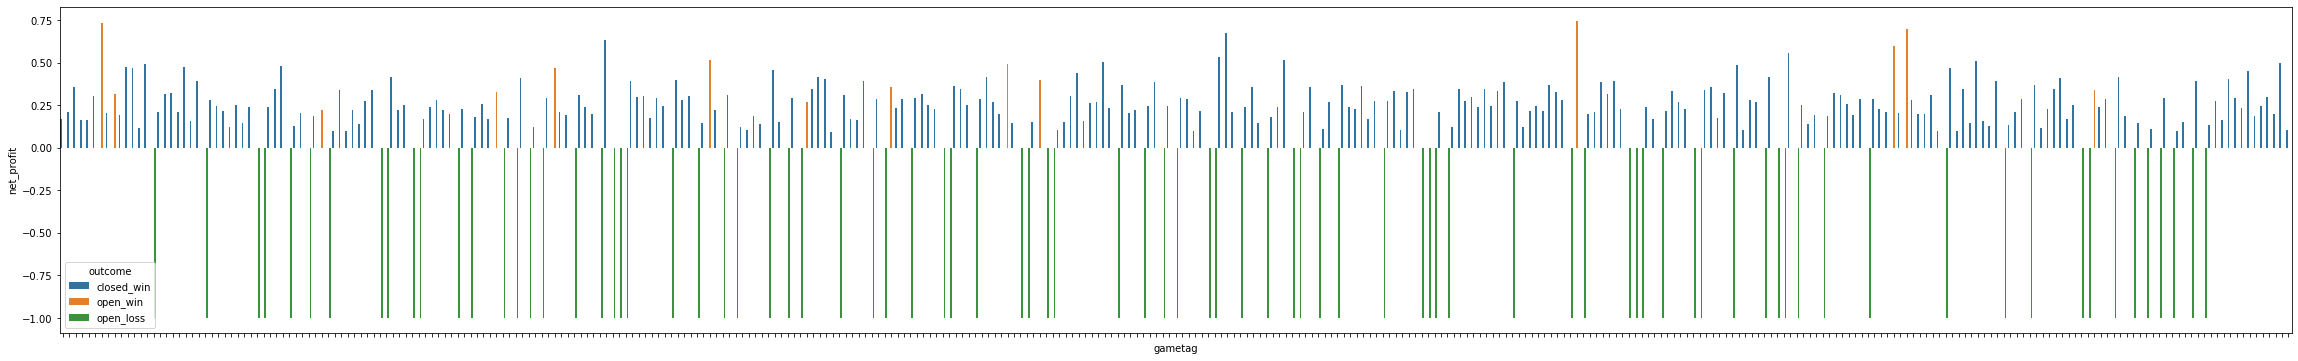

In [105]:
profit_barplot(strat_1_tables[3]) #mins15 == 45

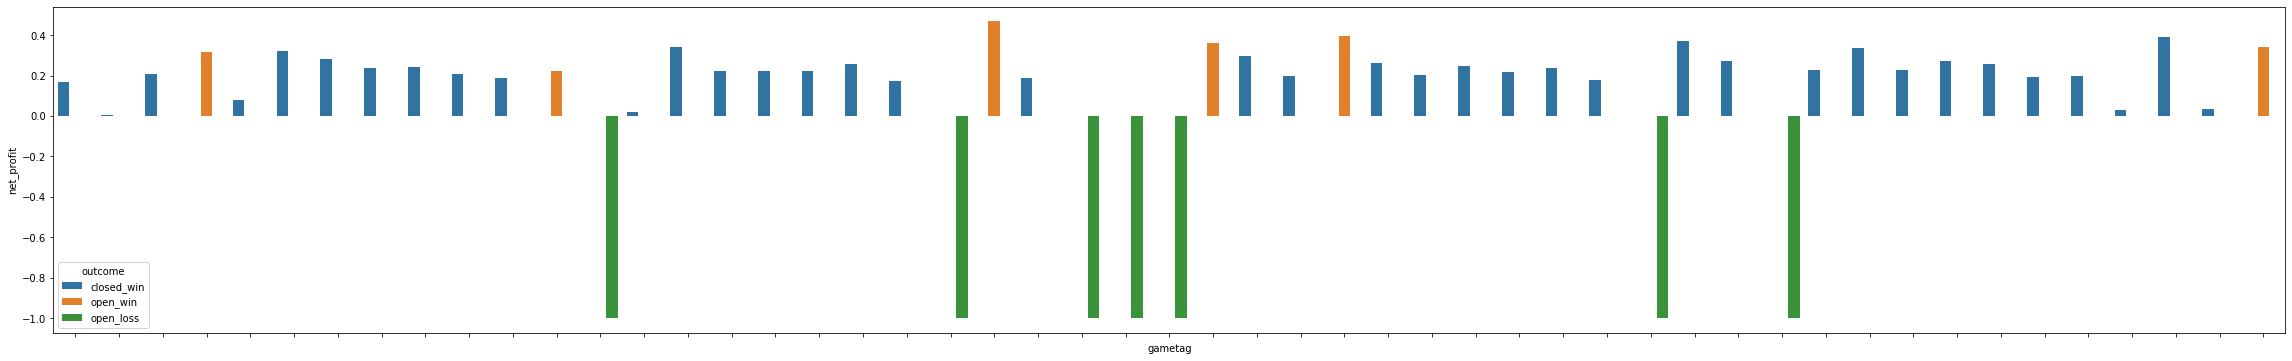

In [106]:
#strategy 2, mins15==45, big favourites, medium scoring likelihood
df_sub = strat_2_tables[3].copy()
profit_barplot(df_sub[(df_sub['back_F_factor'] == df_sub['back_F_factor'].unique().dropna().sort_values()[0]) 
                           & (df_sub['back_noscore_calib_factor'] == 2)])

In [107]:
#51 observations is indeed as expected
profit_pivot(strat_2_tables[2],'count')

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.179, 1.86]",29.0,57.0,25.0,111.0
"(1.86, 2.13]",26.0,59.0,24.0,109.0
"(2.13, 2.46]",24.0,61.0,27.0,112.0
"(2.46, 3.15]",25.0,57.0,26.0,108.0
All,104.0,234.0,102.0,440.0


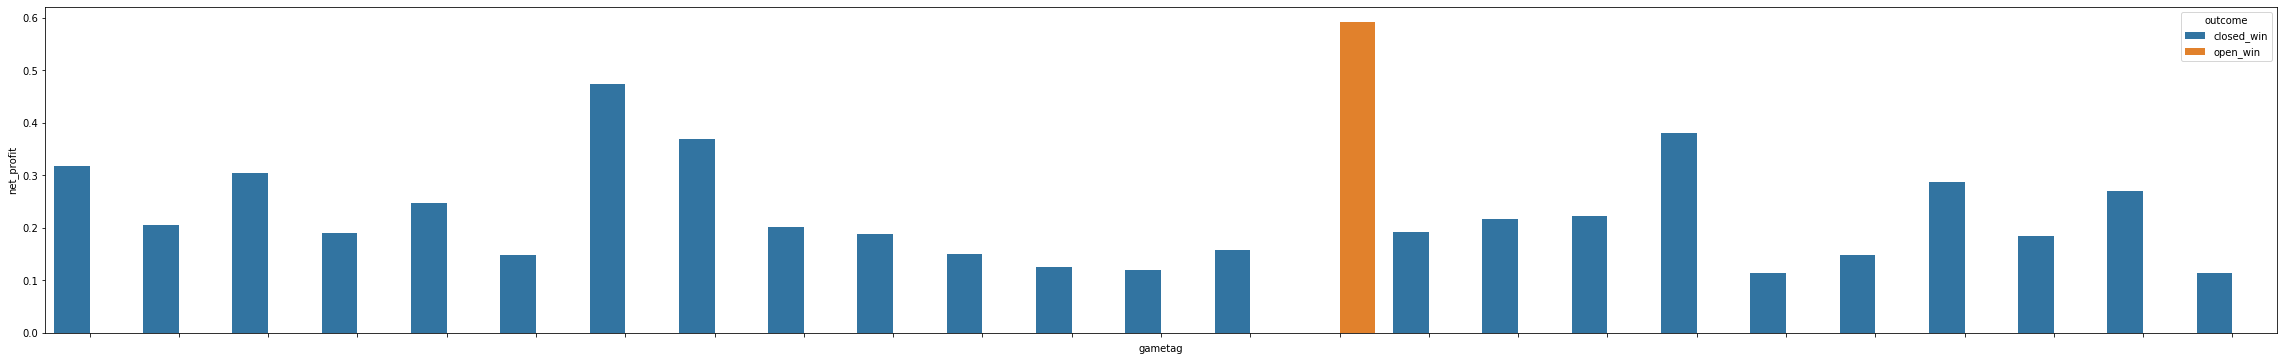

In [108]:
#strategy 1, mins15==45, low favourites, low scoring likelihood
df_sub = strat_1_tables[2].copy()
profit_barplot(df_sub[(df_sub['back_F_factor'] == df_sub['back_F_factor'].unique().dropna().sort_values()[3]) 
                           & (df_sub['back_noscore_calib_factor'] == 1)])

In [109]:
#17 observations is indeed as expected
profit_pivot(strat_1_tables[2],'count')

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.179, 1.86]",29.0,57.0,25.0,111.0
"(1.86, 2.13]",26.0,59.0,24.0,109.0
"(2.13, 2.46]",24.0,61.0,27.0,112.0
"(2.46, 3.15]",25.0,57.0,26.0,108.0
All,104.0,234.0,102.0,440.0


# Visualizations for net profit per category

### Net profit per favourite category, for every LTD_start and both strategies

In [110]:
results = pd.DataFrame(columns=['fav_cat','net_profit','LTD_start','strategy'])

for (nr,i) in enumerate([strat_1_mean_pivots, strat_2_mean_pivots]):
    for j in np.arange(0,6,1):
        x = pd.DataFrame(i[j]['All'].drop('All'))
        x.index = ['F++++','F+++','F++','F+']
        x.reset_index(drop=False,inplace=True)
        x.columns = ['fav_cat','net_profit']
        x['LTD_start'] = starts[j]
        x['strategy'] = nr+1
        results = results.append(x,ignore_index=True)

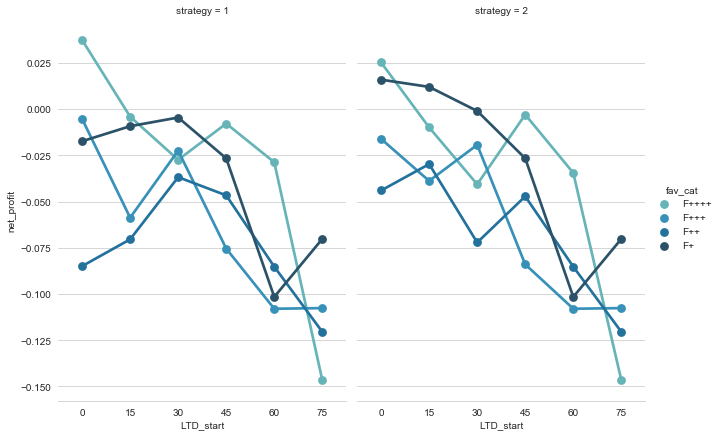

In [111]:
sns.set_style("whitegrid")
g = sns.catplot(x="LTD_start", y="net_profit", hue="fav_cat", col="strategy",
                capsize=.2, palette="YlGnBu_d", height=6, aspect=.75,
                kind="point", data=results)
g.despine(left=True)

Overall we can conclude that:
- the LTD strategy has been a losing strategy if used on all games in the sample dataset
- against the "expert advice", most of the time it doesn't seem to be a good idea to start the strategy later

However it did make a profit for:
- big favourites with strategy 1 or 2, LTD start = 0
- slight favourites with strategy 2, LTD start = 0

### Impact of scoring likelihood

We will single out those last 2 game categories and visualize the difference in net_profit in relation to the scoring likelihood:

In [112]:
results_scoring_lik = pd.DataFrame(columns=['scoring_likelihood','net_profit','LTD_start','strategy_fav'])

for (nr,i) in enumerate(['strat_1_big_fav', 'strat_2_slight_fav']):
    for j in np.arange(0,6,1):
        pivots = [strat_1_mean_pivots,strat_2_mean_pivots]
        data=pivots[nr]
        fav_ilocs = [0,3] #first row for the big and 4th row for the slight fav
        fav_iloc = fav_ilocs[nr]
        x = pd.DataFrame(data[j].iloc[fav_iloc]).drop('All')
        x.columns = ['net_profit']
        x.reset_index(drop=False,inplace=True)
        x.columns = ['scoring_likelihood','net_profit']
        x['LTD_start'] = starts[j]
        x['strategy_fav'] = i
        results_scoring_lik = results_scoring_lik.append(x,ignore_index=True)

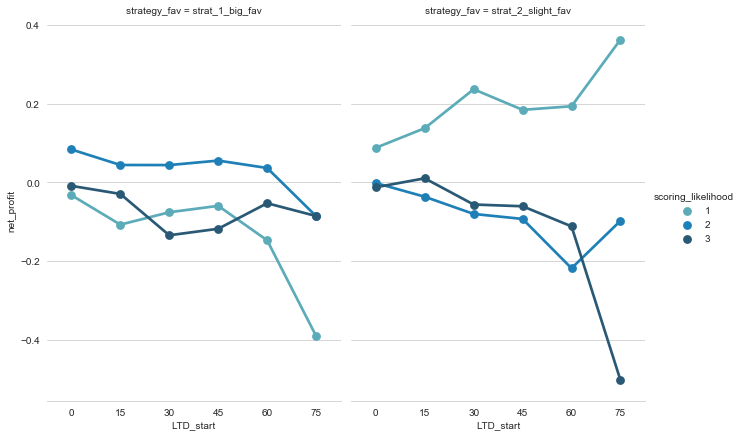

In [113]:
g = sns.catplot(x="LTD_start", y="net_profit", hue="scoring_likelihood", col="strategy_fav",
                capsize=.2, palette="YlGnBu_d", height=6, aspect=.75,
                kind="point", data=results_scoring_lik)
g.despine(left=True)

For each of the 'winning' strategies there is an obvious outperforming scoring_likelihood category:
- medium scoring likelihood for the big favourites (strategy 1 in this plot)
- low scoring likelihood for the slight favourites (strategy 2)

Again, all under consideration of low number observations for certain categories, especially for later LTD_starts.

### The full picture

We now make a 4 by 2 facet grid to capture all the info at once.

In [114]:
results_all_flat = pd.DataFrame(columns=['fav_cat','scoring_likelihood','net_profit','LTD_start','strategy'])

for (nr,i) in enumerate([strat_1_mean_pivots, strat_2_mean_pivots]):
    for j in np.arange(0,6,1):
        x = pd.DataFrame(i[j].drop('All').drop('All',axis=1))
        x.index = ['F++++','F+++','F++','F+']
        x.reset_index(drop=False,inplace=True)
        x = x.melt(id_vars=["index"], var_name="scoring_likelihood", value_name="net_profit")
        x.columns = ['fav_cat','scoring_likelihood','net_profit']
        x['LTD_start'] = starts[j]
        x['strategy'] = nr+1
        results_all_flat = results_all_flat.append(x,ignore_index=True)

<Figure size 720x1440 with 0 Axes>

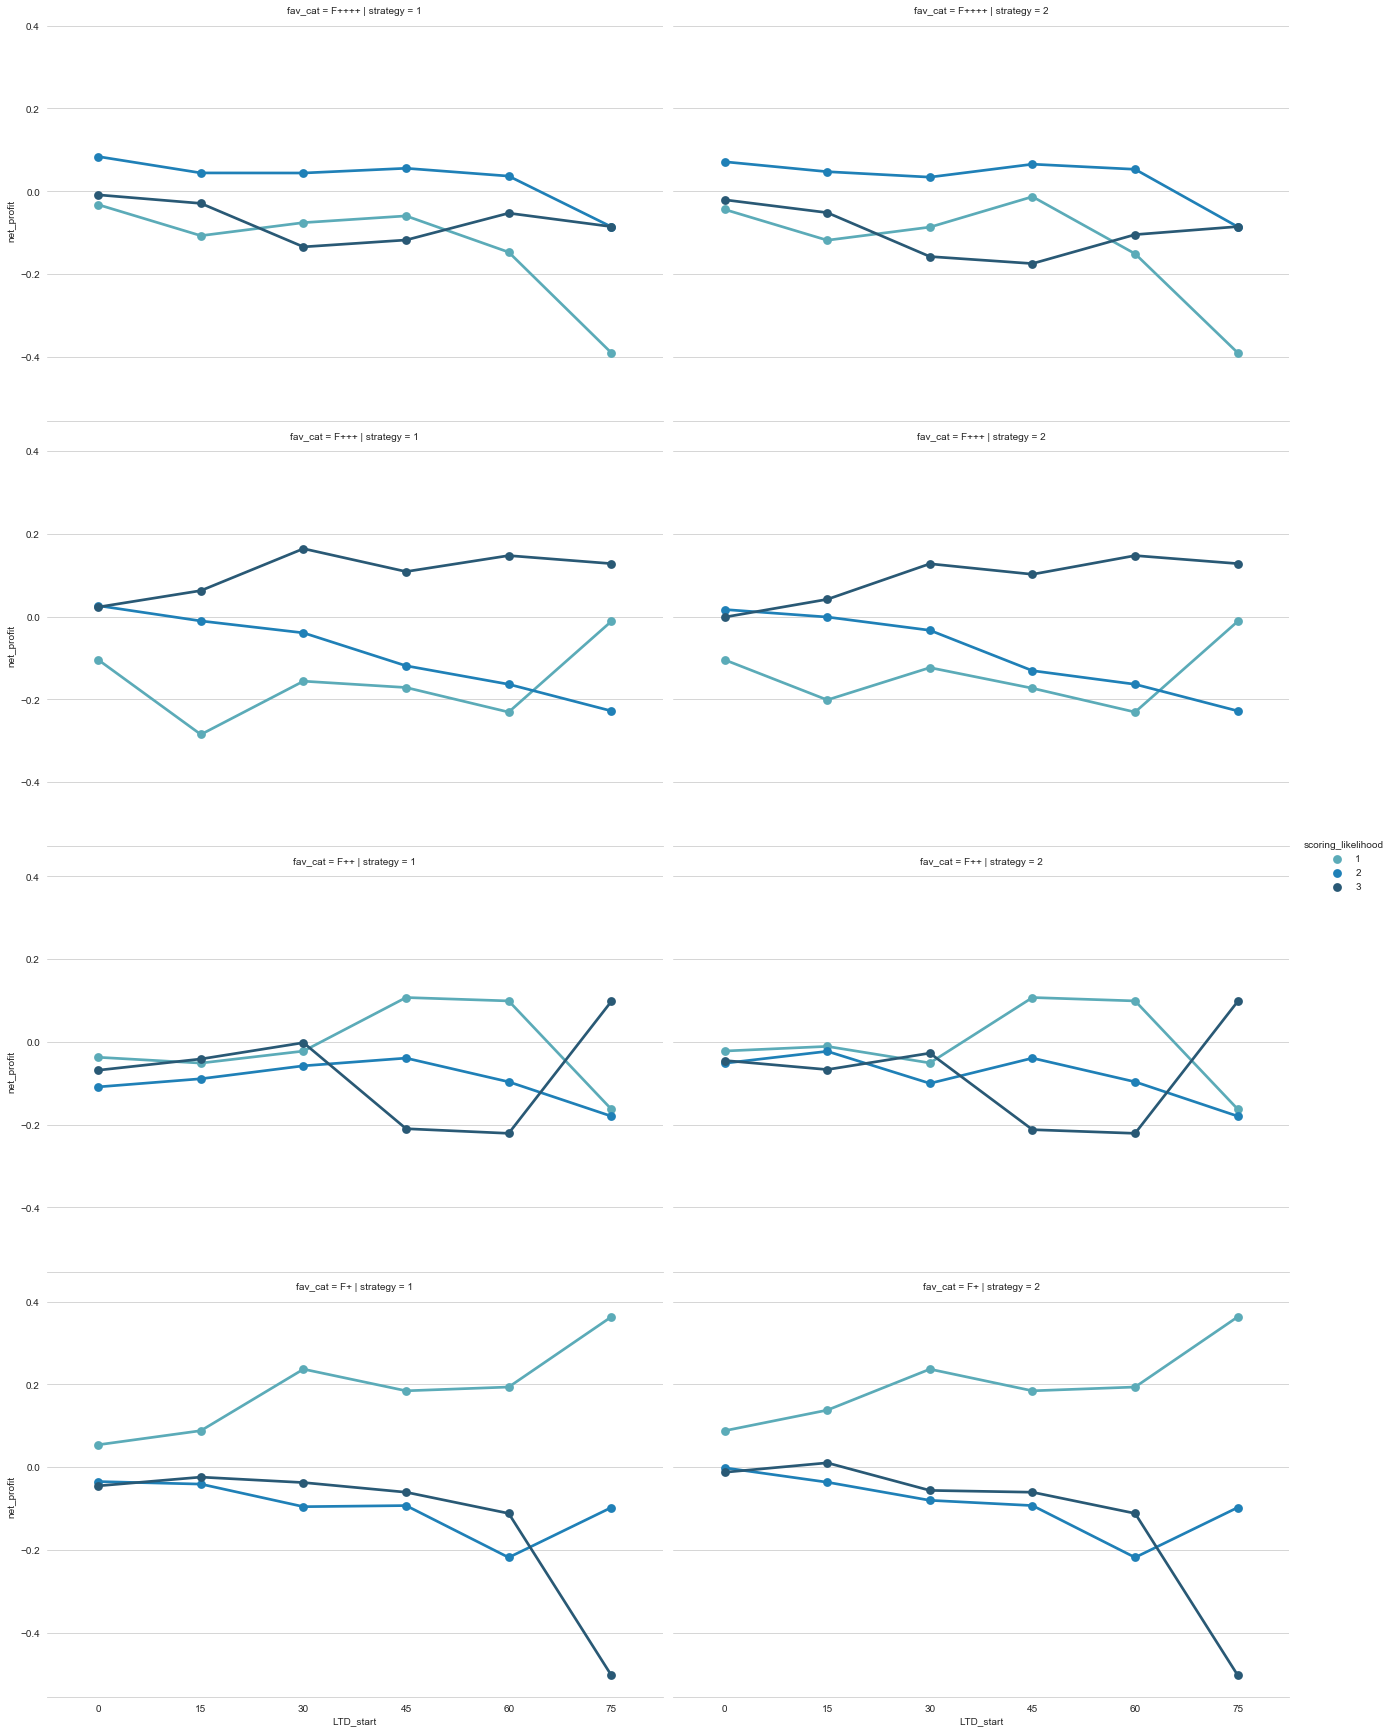

In [115]:
sns.set_style("whitegrid")
plt.figure(figsize = (10,20))
g = sns.catplot(x="LTD_start", y="net_profit", hue="scoring_likelihood", row="fav_cat", col="strategy",
                capsize=.2, palette="YlGnBu_d", height=6, aspect=1.5,
                kind="point", data=results_all_flat)
g.despine(left=True)

In [ ]:
g.savefig("./output/net_profits_4x2.png")

# Conclusions

<img src="../0 images/net_profits_edit.png">

The following game/timing selections seem to outperform the others:

In [116]:
r = results_all_flat.copy()
succ_strat = r[((r['fav_cat'] == 'F++++') & (r['scoring_likelihood'] == 2) & (r['LTD_start'] == 0) & (r['strategy'] == 1)) |
                 ((r['fav_cat'] == 'F+++') & (r['scoring_likelihood'] == 2) & (r['LTD_start'] == 0) & (r['strategy'] == 1)) |
                 ((r['fav_cat'] == 'F+++') & (r['scoring_likelihood'] == 3) & (r['LTD_start'] == 30) & (r['strategy'] == 1)) |
                 ((r['fav_cat'] == 'F++') & (r['scoring_likelihood'] == 1) & (r['LTD_start'] == 45) & (r['strategy'] == 1)) |
                 ((r['fav_cat'] == 'F+') & (r['scoring_likelihood'] == 1) & (r['LTD_start'] == 30) & (r['strategy'] == 1))].sort_values('fav_cat',ascending=False).reset_index(drop=True)
succ_strat

,fav_cat,scoring_likelihood,net_profit,LTD_start,strategy
0,F++++,2,0.083679,0,1
1,F+++,2,0.026139,0,1
2,F+++,3,0.163927,30,1
3,F++,1,0.107037,45,1
4,F+,1,0.236661,30,1


Of course we should not overstate these results, considering the number of observations per group:

In [117]:
succ_strat.loc[0,'game_count'] = strat_1_count_pivots[0].iloc[0,1]
succ_strat.loc[1,'game_count'] = strat_1_count_pivots[0].iloc[1,1]
succ_strat.loc[2,'game_count'] = strat_1_count_pivots[2].iloc[1,2]
succ_strat.loc[3,'game_count'] = strat_1_count_pivots[3].iloc[2,0]
succ_strat.loc[4,'game_count'] = strat_1_count_pivots[2].iloc[3,0]
succ_strat

,fav_cat,scoring_likelihood,net_profit,LTD_start,strategy,game_count
0,F++++,2,0.083679,0,1,116.0
1,F+++,2,0.026139,0,1,110.0
2,F+++,3,0.163927,30,1,24.0
3,F++,1,0.107037,45,1,20.0
4,F+,1,0.236661,30,1,25.0


# Balance fluctuation

How much variation is there in the balance if we play all games of a certain category?

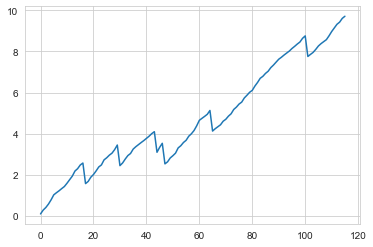

In [118]:
st = strat_1_game_summaries[0]
fav_cat = st['back_F_factor'].unique().sort_values()[0] #F++++
st_sub = st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 2)]
st_sub.to_excel('profit_summary_table_big_fav_mins0_medium_sl.xlsx',index=False)
plt.plot(st_sub['net_profit'].cumsum().reset_index(drop=True))

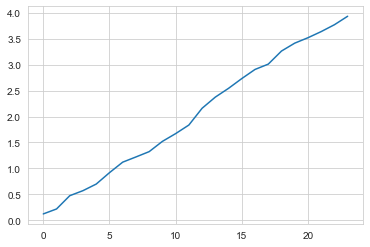

In [119]:
st = strat_1_game_summaries[2]
fav_cat = st['back_F_factor'].unique().sort_values()[1] #F+++
st_sub = st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 3)]
st_sub.to_excel('profit_summary_table_mediumhigh_fav_mins30_high_sl.xlsx',index=False)
plt.plot(st_sub['net_profit'].cumsum().reset_index(drop=True))

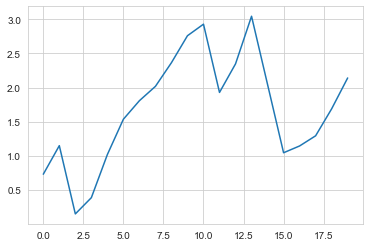

In [120]:
st = strat_1_game_summaries[3]
fav_cat = st['back_F_factor'].unique().sort_values()[2] #F++
st_sub = st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 1)]
st_sub.to_excel('profit_summary_table_mediumlow_fav_mins45_low_sl.xlsx',index=False)
plt.plot(st_sub['net_profit'].cumsum().reset_index(drop=True))

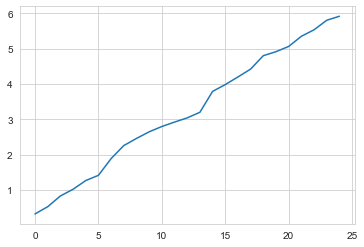

In [121]:
st = strat_1_game_summaries[2]
fav_cat = st['back_F_factor'].unique().sort_values()[3] #F+
st_sub = st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 1)]
st_sub.to_excel('profit_summary_table_low_fav_mins30_low_sl.xlsx',index=False)
plt.plot(st_sub['net_profit'].cumsum().reset_index(drop=True))

And what if we would play strategy 2 on all the slight favourites from mins=0, not considering the scoring likelihood?
- 206 games
- 2,9% mean net profit 

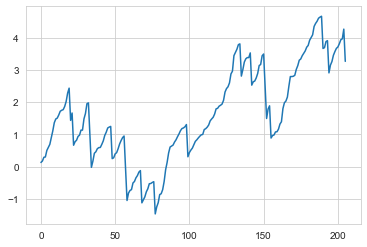

In [122]:
st = strat_2_game_summaries[0]
fav_cat = st['back_F_factor'].unique().sort_values()[3] #F+
st_sub = st[(st['back_F_factor'] == fav_cat)]
st_sub.to_excel('profit_summary_table_low_fav_mins0.xlsx',index=False)
plt.plot(st_sub['net_profit'].cumsum().reset_index(drop=True))

# Write all results for analysis

In [123]:
results_all_means = pd.DataFrame(columns=['fav_cat','1','2','3','All','LTD_start','strategy'])

for (nr,i) in enumerate([strat_1_mean_pivots, strat_2_mean_pivots]):
    for j in np.arange(0,6,1):
        x = pd.DataFrame(i[j])
        x.index = ['F++++','F+++','F++','F+','All']
        x.reset_index(drop=False,inplace=True)
        x.columns = ['fav_cat','1','2','3','All']
        x['LTD_start'] = starts[j]
        x['strategy'] = nr+1
        results_all_means = results_all_means.append(x,ignore_index=True)

In [124]:
results_all_sums = pd.DataFrame(columns=['fav_cat','1','2','3','All','LTD_start','strategy'])

for (nr,i) in enumerate([strat_1_sum_pivots, strat_2_sum_pivots]):
    for j in np.arange(0,6,1):
        x = pd.DataFrame(i[j])
        x.index = ['F++++','F+++','F++','F+','All']
        x.reset_index(drop=False,inplace=True)
        x.columns = ['fav_cat','1','2','3','All']
        x['LTD_start'] = starts[j]
        x['strategy'] = nr+1
        results_all_sums = results_all_sums.append(x,ignore_index=True)

In [125]:
results_all_counts = pd.DataFrame(columns=['fav_cat','1','2','3','All','LTD_start','strategy'])

for (nr,i) in enumerate([strat_1_count_pivots, strat_2_count_pivots]):
    for j in np.arange(0,6,1):
        x = pd.DataFrame(i[j])
        x.index = ['F++++','F+++','F++','F+','All']
        x.reset_index(drop=False,inplace=True)
        x.columns = ['fav_cat','1','2','3','All']
        x['LTD_start'] = starts[j]
        x['strategy'] = nr+1
        results_all_counts = results_all_counts.append(x,ignore_index=True)

In [ ]:
results_all_sums.to_excel('./output/results_all_sums.xlsx',index=False)
results_all_counts.to_excel('./output/results_all_counts.xlsx',index=False)
results_all_means.to_excel('./output/results_all_means.xlsx',index=False)

### Plot back_F categories over time

In [126]:
back_F_cutoffs = pd.DataFrame(columns=['1','2','3','4','5','mins'], data=np.zeros((6,6)))

for i in np.arange(0,6,1):
    back_F_cutoffs.iloc[i,5] = starts[i]
    first = np.round(strat_1_tables[i]['back_F_factor'].unique().dropna().sort_values()[0].left,2)
    back_F_cutoffs.iloc[i,0] = first
    for j in np.arange(0,4,1):
        cut = np.trunc(strat_1_tables[i]['back_F_factor'].unique().dropna().sort_values()[j].right*100)/100
        back_F_cutoffs.iloc[i,j+1] = cut

back_F_cutoffs

,1,2,3,4,5,mins
0,1.12,1.68,1.97,2.29,3.00,0.0
1,1.12,1.74,2.02,2.36,3.05,15.0
2,1.18,1.86,2.13,2.46,3.15,30.0
3,1.29,2.06,2.42,2.78,3.60,45.0
4,1.19,2.34,2.69,3.10,4.20,60.0
5,1.16,3.10,3.55,4.09,6.00,75.0


In [127]:
back_F_cutoffs_melted = back_F_cutoffs.melt(id_vars=["mins"], var_name="fav_cat_cutoff", value_name="back_F")

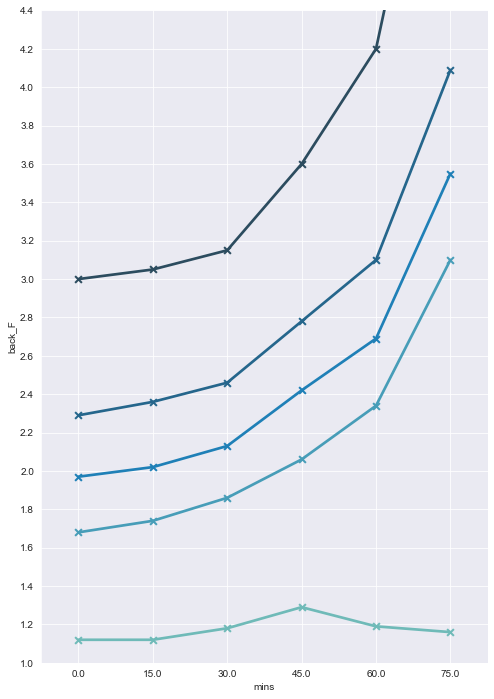

In [128]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(8,12))

sns.pointplot(x="mins", y="back_F", hue="fav_cat_cutoff",
                capsize=.2, palette="YlGnBu_d", height=6, aspect=2,
                markers = 'x', data=back_F_cutoffs_melted, ax=ax)

ax.set_ylim(1,4.4)
ax.set_yticks(np.arange(1,4.6,0.2))
plt.grid(True)
plt.legend([],[], frameon=False)
plt.show()

In [129]:
back_F_cutoffs.set_index('mins')

,1,2,3,4,5
mins,,,,,
0.0,1.12,1.68,1.97,2.29,3.00
15.0,1.12,1.74,2.02,2.36,3.05
30.0,1.18,1.86,2.13,2.46,3.15
45.0,1.29,2.06,2.42,2.78,3.60
60.0,1.19,2.34,2.69,3.10,4.20
75.0,1.16,3.10,3.55,4.09,6.00


In [ ]:
fig.savefig("./output/fav_cat_cutoffs.png")

### Plot noscore_calib categories per mins15

In [130]:
#back_noscore_calib_factor cutoffs per back_F category
pd.crosstab(index=strat_1_tables[3]['back_F_factor'],columns=strat_1_tables[3]['back_noscore_calib_factor'],values=strat_1_tables[3]['back_noscore_calib'],aggfunc=min)

back_noscore_calib_factor,1,2,3
back_F_factor,,,
"(1.2890000000000001, 2.06]",6.8,14.0,23.0
"(2.06, 2.42]",6.8,10.5,17.0
"(2.42, 2.78]",5.5,8.6,15.5
"(2.78, 3.6]",5.7,8.4,14.5


In [131]:
#back_noscore_calib_factor cutoffs per back_F category, T=0
t = strat_1_tables[3]
noscore_cutoffs = pd.crosstab(index=t['back_F_factor'],columns=t['back_noscore_calib_factor'],
                              values=t['back_noscore_calib'],aggfunc=min)
noscore_cutoffs['4'] = t.groupby('back_F_factor')['back_noscore_calib'].max()
noscore_cutoffs = noscore_cutoffs.reset_index(drop=False)
noscore_cutoffs = noscore_cutoffs.sort_values('back_F_factor')
noscore_cutoffs.columns = ['fav_cat','1','2','3','4']
noscore_cutoffs.loc[:,'fav_cat'] = ['F++++','F+++','F++','F+']
noscore_cutoffs

,fav_cat,1,2,3,4
0,F++++,6.8,14.0,23.0,55.0
1,F+++,6.8,10.5,17.0,22.0
2,F++,5.5,8.6,15.5,24.0
3,F+,5.7,8.4,14.5,24.0


In [132]:
noscore_cutoffs_melted = noscore_cutoffs.melt(id_vars=["fav_cat"], var_name="noscore_cat_cutoff", value_name="back_noscore")
noscore_cutoffs_melted

,fav_cat,noscore_cat_cutoff,back_noscore
0,F++++,1,6.8
1,F+++,1,6.8
2,F++,1,5.5
3,F+,1,5.7
4,F++++,2,14.0
5,F+++,2,10.5
6,F++,2,8.6
7,F+,2,8.4
8,F++++,3,23.0
9,F+++,3,17.0


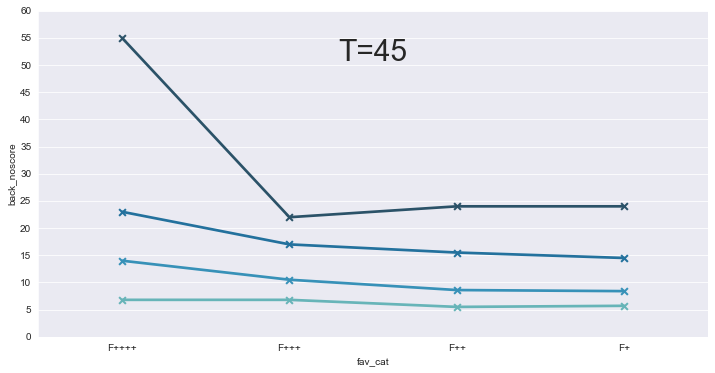

In [133]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(12,6))

sns.pointplot(x="fav_cat", y="back_noscore", hue="noscore_cat_cutoff",
                capsize=.2, palette="YlGnBu_d", height=6, aspect=2,
                markers = 'x', data=noscore_cutoffs_melted, ax=ax)

ax.set_ylim(0,60)
ax.set_yticks(np.arange(0,65,5))
#plt.grid(True)
plt.legend([],[], frameon=False)
plt.title('T=45',fontdict={'fontsize':30},pad=-50)
plt.show()

In [ ]:
fig.savefig("./output/noscore_cat_cutoffs_T45.png")